## Following Best Practices from link
- https://freedium-mirror.cfd/https://medium.com/coding-nexus/search-40m-documents-in-under-200ms-on-a-cpu-using-binary-embeddings-and-int8-rescoring-4f5d34ad11ab
- https://www.elastic.co/search-labs/blog/better-binary-quantization-lucene-elasticsearch
- https://huggingface.co/blog/embedding-quantization
 
Authors:
    Resti Febriana (resti.febriana@gdplabs.id)

Reviewer:
    

## Setup and Configuration

In [1]:
!pip install pandas numpy matplotlib seaborn elasticsearch openai python-dotenv psutil nest-asyncio
!pipx install uv
!uv pip install --extra-index-url "https://oauth2accesstoken:$(gcloud auth print-access-token)@glsdk.gdplabs.id/gen-ai-internal/simple/" gllm-evals
!python -m pip install agentevals deepeval ragas

'uv' already seems to be installed. Not modifying existing installation in
'/home/resti/.local/pipx/venvs/uv'. Pass '--force' to force installation.
Using Python 3.12.0 environment at: /home/resti/anaconda3/envs/quantization
Resolved 156 packages in 3.19s                                       
Uninstalled 1 package in 10ms
Installed 1 package in 7ms                                  
 - datasets==4.5.0
 + datasets==3.6.0
  Using cached datasets-4.5.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-4.5.0-py3-none-any.whl (515 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gllm-evals 0.0.40 requires datasets<4.0.0,>=3.6.0, but you have datasets 4.5.0 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import time
import json
import ast
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import psutil
import os
import sys
from pathlib import Path
import asyncio


from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from openai import OpenAI

# Import ClassicalRetrievalEvaluator
# Adjust the import path based on your project structure
# sys.path.append('/path/to/gllm_evals')
from gllm_evals.evaluator.classical_retrieval_evaluator import (
    ClassicalRetrievalEvaluator,
    ClassicalRetrievalMetric
)
from gllm_evals.types import RetrievalData

load_dotenv()
client = OpenAI()

ES_URL = os.getenv("ES_URL")
if not ES_URL:
    raise ValueError("ES_URL belum diset di .env")

ES_USERNAME = os.getenv("ES_USERNAME")
ES_PASSWORD = os.getenv("ES_PASSWORD")

kwargs = {"request_timeout": 120}
kwargs["basic_auth"] = (ES_USERNAME, ES_PASSWORD)

es = Elasticsearch(ES_URL, **kwargs)

OUTPUT_DIR = Path.cwd() / "quantization_results"
OUTPUT_DIR.mkdir(exist_ok=True)

CSV_PATH = "/home/resti/glair/gen-ai/notebook_experiment/experiment_embedding_quantization/data_test/embedding_catapa_test_data.csv"
INDICES = {
    "float32": "claudiagpt_dev_catapa_platform_development",
    "int8": "claudiagpt_dev_catapa_platform_development_int8",
    "bbq": "claudiagpt_dev_catapa_platform_development_bbq"
}

print("✅ Setup complete")
print(f"ES cluster: {es.info()['cluster_name']}")
print(f"Output directory: {OUTPUT_DIR}")

✅ Setup complete


2026-01-28T19:56:33 INFO      GET http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/              ]8;id=895946;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=889283;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\

ES cluster: gdplabs-gen-ai-starter-cluster
Output directory: /home/resti/glair/gen-ai/notebook_experiment/experiment_embedding_quantization/quantization_results


## Load and Prepare Test Data

In [3]:
df = pd.read_csv(CSV_PATH)

def parse_expected_ids(x) -> List[str]:
    """Parse expected chunk ids into list[str] robustly."""
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []
    # Already a list/tuple
    if isinstance(x, (list, tuple, set)):
        return [str(i) for i in x if i is not None and str(i) != ""]
    # Numpy scalar
    if isinstance(x, (np.generic,)):
        x = x.item()
    # If it's a dict, try common keys
    if isinstance(x, dict):
        for k in ("chunk_id","id","chunkId"):
            if k in x:
                return [str(x[k])]
        return [str(x)]
    s = str(x).strip()
    if not s or s.lower() in ("nan","none","null"):
        return []
    # Try JSON list first
    try:
        import json as _json
        parsed = _json.loads(s)
        if isinstance(parsed, list):
            return [str(i) for i in parsed if i is not None and str(i) != ""]
        if isinstance(parsed, str):
            return [parsed]
    except Exception:
        pass
    # Try Python literal list
    try:
        parsed = ast.literal_eval(s)
        if isinstance(parsed, (list, tuple, set)):
            return [str(i) for i in parsed if i is not None and str(i) != ""]
        if isinstance(parsed, str):
            return [parsed]
    except Exception:
        pass
    # Fallback: single id
    return [s]
    try:
        return ast.literal_eval(ids_str)
    except:
        return []

df["expected_ids"] = df["expected_chunk_id"].apply(parse_expected_ids)
df = df[df["expected_ids"].apply(len) > 0].reset_index(drop=True)

print(f"📊 Loaded {len(df)} test questions")
print("Sample questions:")
for i in range(min(3, len(df))):
    q = df.iloc[i]["question"]
    print(f"  {i+1}. {q[:80]}...")

df.head()

📊 Loaded 70 test questions
Sample questions:
  1. How is CATAPA’s mission reflected in its company culture and core values?...
  2. How did CATAPA’s early history influence its current product focus and features?...
  3. How does CATAPA’s micro team structure support its mission to improve payroll ex...


,no,question,expected_response,expected_chunk_id,expected_chunk_automated,expected_chunk,expected_chunk_sheet_automated,expected_chunk_sheet,expected_chunk_total,notes,expected_ids
0,1,How is CATAPA’s mission reflected in its compa...,CATAPA’s mission is to improve the payroll exp...,"[""152610-StructuredElementChunker-1800-360-400...",CATAPA Introduction\nMY Creator Muhammad Yanza...,CATAPA Introduction\nMY Creator Muhammad Yanza...,"catapa_source_3, catapa_source_3","catapa_source_3, catapa_source_3",2,NaN,[152610-StructuredElementChunker-1800-360-4000...
1,2,How did CATAPA’s early history influence its c...,CATAPA started in Q4 2015 as an internal proje...,"[""152610-StructuredElementChunker-1800-360-400...",Mission\nImprove payroll experience through te...,Mission\nImprove payroll experience through te...,"catapa_source_3, catapa_source_3","catapa_source_3, catapa_source_3",2,NaN,[152610-StructuredElementChunker-1800-360-4000...
2,3,How does CATAPA’s micro team structure support...,CATAPA’s micro team structure divides responsi...,"[""152610-StructuredElementChunker-1800-360-400...",CATAPA Introduction\nMY Creator Muhammad Yanza...,CATAPA Introduction\nMY Creator Muhammad Yanza...,"catapa_source_3, catapa_source_3","catapa_source_3, catapa_source_3",2,NaN,[152610-StructuredElementChunker-1800-360-4000...
3,4,Apa visi CATAPA dan bagaimana filosofi pohon k...,Visi CATAPA adalah menjadi platform payroll gl...,"[""152610-StructuredElementChunker-1800-360-400...",CATAPA Introduction\nMY Creator Muhammad Yanza...,CATAPA Introduction\nMY Creator Muhammad Yanza...,"catapa_source_3, catapa_source_3","catapa_source_3, catapa_source_3",2,NaN,[152610-StructuredElementChunker-1800-360-4000...
4,5,Which roles and teams are involved in ensuring...,Tax and employment regulation compliance is su...,"[""152610-StructuredElementChunker-1800-360-400...",Team Structure (Role)\n1. Business Development...,Team Structure (Role)\n1. Business Development...,"catapa_source_3, catapa_source_3","catapa_source_3, catapa_source_3",2,NaN,[152610-StructuredElementChunker-1800-360-4000...


## Initialize ClassicalRetrievalEvaluator

In [4]:
import ast
import json
import math
import numpy as np
import pandas as pd
import asyncio
import nest_asyncio
nest_asyncio.apply()

from gllm_evals.types import RetrievalData
from gllm_evals.evaluator.classical_retrieval_evaluator import (
    ClassicalRetrievalEvaluator,
    ClassicalRetrievalMetric,
)

def parse_ids(val):
    """Parse various CSV-ish representations into list[str]."""
    if val is None:
        return []
    try:
        if isinstance(val, float) and pd.isna(val):
            return []
    except Exception:
        pass

    if isinstance(val, (list, tuple, set)):
        return [str(x) for x in val if x is not None and str(x).strip()]

    if isinstance(val, str):
        s = val.strip()
        if not s or s.lower() in {"none", "null", "nan"}:
            return []
        try:
            j = json.loads(s)
            if isinstance(j, list):
                return [str(x) for x in j if str(x).strip()]
            if isinstance(j, str) and j.strip():
                return [j]
        except Exception:
            pass
        try:
            p = ast.literal_eval(s)
            if isinstance(p, list):
                return [str(x) for x in p if str(x).strip()]
            if isinstance(p, str) and p.strip():
                return [p]
        except Exception:
            return [s] if s else []

    return [str(val)] if str(val).strip() else []


def build_retrieved_chunks_from_ids(retrieved_ids, k):
    """Build dict[id -> score]. If you don't have ES scores, use rank-based scores."""
    ids = [str(x) for x in retrieved_ids if x is not None and str(x).strip()][:k]
    return {cid: float(len(ids) - i) for i, cid in enumerate(ids)}


def unwrap_score_dict(result_dict):
    """Handle nested structure from ClassicalRetrievalEvaluator"""
    if not result_dict:
        return {}
    
    if len(result_dict) == 1:
        single_key = list(result_dict.keys())[0]
        single_value = result_dict[single_key]
        
        if isinstance(single_value, dict) and any(
            '@' in str(k) for k in single_value.keys()
        ):
            result_dict = single_value
    
    out = {}
    for k, v in result_dict.items():
        if k == "global_explanation":
            continue
        
        if isinstance(v, dict) and "score" in v:
            sc = v.get("score")
            if isinstance(sc, (int, float, np.number)):
                out[k] = float(sc)
        elif isinstance(v, (int, float, np.number)):
            out[k] = float(v)
    
    return out


def alias_classical_keys(flat):
    """Create canonical columns expected by plotting cells."""
    aliased = dict(flat)
    for k, v in list(flat.items()):
        if not isinstance(k, str):
            continue
        if "@" in k:
            base, kk = k.split("@", 1)
            kk = kk.strip()
            if kk.isdigit() and isinstance(v, (int, float, np.number)):
                if base == "precision":
                    aliased[f"P_{kk}"] = float(v)
                elif base == "recall":
                    aliased[f"recall_{kk}"] = float(v)
                elif base == "ndcg":
                    aliased[f"ndcg_cut_{kk}"] = float(v)
                elif base == "map":
                    aliased[f"map_cut_{kk}"] = float(v)
                elif base == "top_k_accuracy":
                    aliased[f"top_k_accuracy_{kk}"] = float(v)
    return aliased


classical_evaluator = ClassicalRetrievalEvaluator(
    metrics=[
        ClassicalRetrievalMetric.NDCG,
        ClassicalRetrievalMetric.RECALL,
        ClassicalRetrievalMetric.MAP,
        ClassicalRetrievalMetric.PRECISION,
        ClassicalRetrievalMetric.TOP_K_ACCURACY,
    ],
    k=[1, 5, 10],
)

print("✅ ClassicalRetrievalEvaluator initialized")
print(f"   Metrics: {classical_evaluator.metrics}")
print(f"   k_values: {classical_evaluator.k_values}")


✅ ClassicalRetrievalEvaluator initialized
   Metrics: [<ClassicalRetrievalMetric.NDCG: 'ndcg'>, <ClassicalRetrievalMetric.RECALL: 'recall'>, <ClassicalRetrievalMetric.MAP: 'map'>, <ClassicalRetrievalMetric.PRECISION: 'precision'>, <ClassicalRetrievalMetric.TOP_K_ACCURACY: 'top_k_accuracy'>]
   k_values: [1, 5, 10]


## Embedding Function

In [5]:
def embed_question_to_1536(question: str) -> List[float]:
    """Embed question using OpenAI text-embedding-3-small"""
    response = client.embeddings.create(
        input=question,
        model="text-embedding-3-small",
        dimensions=1536
    )
    return response.data[0].embedding

print("✅ Embedding function defined")

✅ Embedding function defined


## Retrieval Functions

In [6]:
def knn_search_with_timing(
    index_name: str,
    query_vector: List[float],
    k: int = 10,
    num_candidates: int = 100
) -> Tuple[List[str], Dict[str, float]]:
    """
    Perform KNN search and return chunk IDs with timing.
        
    Args:
        index_name: ES index name (e.g., "float32", "int8", "bbq")
        query_vector: Query embedding vector (1536d)
        k: Number of results to return
        num_candidates: Number of candidates to consider (affects recall)
    
    Returns:
        chunk_ids: List of retrieved chunk IDs
        timing: Dict with timing breakdown in milliseconds
    """
    timing = {}
    
    start = time.perf_counter()
    response = es.search(
        index=index_name,
        size=k,
        knn={
            "field": "vector",
            "query_vector": query_vector,
            "k": k,
            "num_candidates": num_candidates
        },
        _source=["metadata.chunk_id"]
    )
    timing["total"] = (time.perf_counter() - start) * 1000
    
    chunk_ids = [
        hit["_source"]["metadata"]["chunk_id"]
        for hit in response["hits"]["hits"]
    ]
    
    return chunk_ids, timing


def fetch_float32_vectors(index_name: str, chunk_ids: List[str]) -> np.ndarray:
    """Fetch float32 vectors for given chunk IDs from Elasticsearch.

    Args:
        index_name(str): inde

    Returns:
        np.ndarray with shape (len(chunk_ids), dim) or empty array if nothing can be fetched.
    """
    if not chunk_ids:
        return np.array([])

    def _search_terms(terms_field: str) -> Dict[str, List[float]]:
        body = {
            "query": {"bool": {"filter": [{"terms": {terms_field: chunk_ids}}]}},
            "_source": ["metadata.chunk_id", "vector"],
            "size": len(chunk_ids),
        }
        resp = es.search(index=index_name, body=body, request_timeout=120)
        hits = resp.get("hits", {}).get("hits", [])

        vector_map: Dict[str, List[float]] = {}
        for hit in hits:
            src = hit.get("_source", {})
            meta = src.get("metadata", {})
            cid = None
            if isinstance(meta, dict):
                cid = meta.get("chunk_id")
            if cid is None:
                cid = src.get("metadata.chunk_id")
            vec = src.get("vector")
            if cid is not None and vec is not None:
                vector_map[str(cid)] = vec
        return vector_map

    vector_map = _search_terms("metadata.chunk_id.keyword")

    if not vector_map:
        vector_map = _search_terms("metadata.chunk_id")

    if not vector_map:
        return np.array([])

    dim = len(next(iter(vector_map.values())))
    vectors: List[List[float]] = []
    missing = 0

    for cid in chunk_ids:
        if cid in vector_map:
            vectors.append(vector_map[cid])
        else:
            missing += 1
            vectors.append([0.0] * dim)

    if missing:
        missing_pct = (missing / len(chunk_ids)) * 100
        print(f"⚠️  Vector fetch: {missing}/{len(chunk_ids)} missing ({missing_pct:.1f}%), filled with zeros")

    assert len(vectors) == len(chunk_ids), f"ALIGNMENT BROKEN: {len(vectors)} vectors != {len(chunk_ids)} chunk_ids"
    return np.array(vectors, dtype=np.float32)

def two_stage_retrieval(
    qvec: List[float],
    k: int = 10,
    rescore_multiplier: int = 2,
    use_int8_rescore: bool = False
) -> Tuple[List[str], Dict[str, float]]:
    """Two-stage retrieval: Stage-1 BBQ search, Stage-2 float32 (or int8) dot-product rescoring.

    """
    timing: Dict[str, float] = {}

    start = time.perf_counter()
    k_stage1 = k * rescore_multiplier
    stage1_ids, stage1_timing = knn_search_with_timing(
        index_name=INDICES["bbq"],
        query_vector=qvec,
        k=k_stage1,
        num_candidates=k_stage1 * 4
    )
    timing["stage1_bbq_search"] = (time.perf_counter() - start) * 1000

    if not stage1_ids:
        timing["total"] = timing["stage1_bbq_search"]
        return [], timing

    start = time.perf_counter()
    index_to_use = INDICES["int8"] if use_int8_rescore else INDICES["float32"]
    vectors = fetch_float32_vectors(index_to_use, stage1_ids)
    timing["stage2_load_vectors"] = (time.perf_counter() - start) * 1000

    if len(vectors) == 0:
        print("⚠️  Stage-2 vector fetch returned 0 vectors. Falling back to stage-1 results.")
        timing["total"] = sum(timing.values())
        return stage1_ids[:k], timing

    if len(vectors) != len(stage1_ids):
        print(f"⚠️  Alignment mismatch: {len(vectors)} vectors != {len(stage1_ids)} stage1_ids. Falling back to stage-1.")
        timing["total"] = sum(timing.values())
        return stage1_ids[:k], timing

    start = time.perf_counter()
    qvec_np = np.array(qvec, dtype=np.float32)
    scores = np.dot(vectors, qvec_np)
    timing["stage3_rescore"] = (time.perf_counter() - start) * 1000

    start = time.perf_counter()
    top_indices = np.argsort(-scores)[:k]
    final_ids = [stage1_ids[i] for i in top_indices]
    timing["stage4_sort"] = (time.perf_counter() - start) * 1000

    timing["total"] = sum(timing.values())
    return final_ids, timing

print("✅ Retrieval functions defined")

✅ Retrieval functions defined


## Memory Tracking Utilities

In [7]:
class MemoryTracker:
    """Track memory usage during operations"""
    
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.baseline = self.process.memory_info().rss / 1024**2  # MB
    
    def snapshot(self) -> float:
        """Get current memory usage in MB"""
        return self.process.memory_info().rss / 1024**2
    
    def delta(self, baseline: float = None) -> float:
        """Get memory delta from baseline in MB"""
        if baseline is None:
            baseline = self.baseline
        return self.snapshot() - baseline

memory_tracker = MemoryTracker()
print(f"📊 Baseline memory: {memory_tracker.baseline:.2f} MB")

📊 Baseline memory: 914.32 MB


## Evaluation Metrics (Original + Classical)

In [8]:
def calculate_hit_at_k(retrieved: List[str], expected: List[str], k: int) -> bool:
    """Check if any expected ID is in top-k retrieved"""
    return any(exp in retrieved[:k] for exp in expected)


def calculate_mrr(retrieved: List[str], expected: List[str]) -> float:
    """Calculate Mean Reciprocal Rank"""
    for i, ret_id in enumerate(retrieved):
        if ret_id in expected:
            return 1.0 / (i + 1)
    return 0.0


def calculate_all_hit_at_k(retrieved: List[str], expected: List[str], k: int) -> float:
    """Strict metric: 1.0 if ALL expected IDs are present in top-k, else 0.0"""
    expected_set = set(expected)
    if not expected_set:
        return 0.0
    retrieved_k = set(retrieved[:k])
    return float(expected_set.issubset(retrieved_k))



async def calculate_classical_metrics(
    retrieved_ids,
    expected_ids,
    evaluator: ClassicalRetrievalEvaluator,
    debug: bool = False,
) -> Dict[str, float]:
    """
    Compute classical IR metrics via ClassicalRetrievalEvaluator.
    Notes:
      - retrieved_ids / expected_ids may come from CSV as strings; we normalize via parse_ids().
      - evaluator expects RetrievalData(retrieved_chunks: Dict[id->score], ground_truth_chunk_ids: List[id]).
    """
    retrieved_ids = parse_ids(retrieved_ids)
    expected_ids = parse_ids(expected_ids)

    if debug:
        print("GT sample:", expected_ids[:3])
        print("RET sample:", retrieved_ids[:3])
        print("intersection size:", len(set(expected_ids) & set(retrieved_ids)))

    if not retrieved_ids or not expected_ids:
        return {}

    max_k = max(getattr(evaluator, "k_values", [10]) or [10])
    retrieved_chunks = build_retrieved_chunks_from_ids(retrieved_ids, k=max_k)

    retrieval_data = RetrievalData(
        retrieved_chunks=retrieved_chunks,
        ground_truth_chunk_ids=expected_ids,
    )

    try:
        raw = await evaluator.evaluate(retrieval_data)
    except Exception as e:
        print(f"⚠️ Error calculating classical metrics: {e}")
        return {}

    flat = unwrap_score_dict(raw)
    flat = alias_classical_keys(flat)
    return flat


print("✅ Metrics functions defined")

✅ Metrics functions defined


## Main Evaluation Function

In [9]:
def run_evaluation(
    label: str,
    retrieval_fn,
    df: pd.DataFrame,
    k: int = 10,
    **retrieval_kwargs
) -> Tuple[pd.DataFrame, Dict]:
    """
    Run full evaluation for a retrieval method with classical IR metrics
    """

    results = []
    timing_breakdowns = []
    mem_baseline = memory_tracker.snapshot()

    classical_metrics_all = []
    loop = asyncio.get_event_loop()

    for idx, row in df.iterrows():
        question = row["question"]
        expected_ids = parse_ids(row["expected_ids"])

        embed_start = time.perf_counter()
        qvec = embed_question_to_1536(question)
        embed_time = (time.perf_counter() - embed_start) * 1000

        try:
            retrieved_ids, timing = retrieval_fn(qvec, k=k, **retrieval_kwargs)
        except Exception as e:
            print(f"⚠️  Error at row {idx}: {e}")
            retrieved_ids = []
            timing = {"total": 0}

        hit_1 = calculate_hit_at_k(retrieved_ids, expected_ids, 1)
        hit_5 = calculate_hit_at_k(retrieved_ids, expected_ids, 5)
        hit_10 = calculate_hit_at_k(retrieved_ids, expected_ids, 10)
        mrr = calculate_mrr(retrieved_ids, expected_ids)
        all_hit_10 = calculate_all_hit_at_k(retrieved_ids, expected_ids, 10)

        classical_metrics = loop.run_until_complete(
            calculate_classical_metrics(retrieved_ids, expected_ids, classical_evaluator, debug=True)
        )
        classical_metrics_all.append(classical_metrics)

        result = {
            "label": label,
            "row_idx": idx,
            "question": question,
            "expected_ids": expected_ids,
            "retrieved_ids": retrieved_ids,
            "embed_time_ms": embed_time,
            "retrieval_time_ms": timing.get("total", 0),
            "total_time_ms": embed_time + timing.get("total", 0),
            "hit@1": int(hit_1),
            "hit@5": int(hit_5),
            "hit@10": int(hit_10),
            "mrr": mrr,
            "all_hit@10": all_hit_10,
        }

        result.update(classical_metrics)
        results.append(result)
        timing_breakdowns.append(timing)

        if (idx + 1) % 10 == 0:
            print(f"  Progress: {idx + 1}/{len(df)} queries")

    details_df = pd.DataFrame(results)

    summary = {
        "label": label,
        "num_queries": len(df),
        "hit@1": details_df["hit@1"].mean(),
        "hit@5": details_df["hit@5"].mean(),
        "hit@10": details_df["hit@10"].mean(),
        "mrr": details_df["mrr"].mean(),
        "all_hit@10": details_df["all_hit@10"].mean(),
        "avg_embed_time_ms": details_df["embed_time_ms"].mean(),
        "avg_retrieval_time_ms": details_df["retrieval_time_ms"].mean(),
        "avg_total_time_ms": details_df["total_time_ms"].mean(),
        "p50_total_time_ms": details_df["total_time_ms"].quantile(0.5),
        "p95_total_time_ms": details_df["total_time_ms"].quantile(0.95),
        "p95_embed_time_ms": details_df["embed_time_ms"].quantile(0.95),
        "p95_retrieval_time_ms": details_df["retrieval_time_ms"].quantile(0.95),
        "p99_total_time_ms": details_df["total_time_ms"].quantile(0.99),
        "memory_delta_mb": memory_tracker.delta(mem_baseline),
    }

    def _is_number(x) -> bool:
        return isinstance(x, (int, float, np.number))

    def _normalize_suffix(s) -> str:
        if isinstance(s, (int, np.integer)):
            return str(int(s))
        if isinstance(s, str) and s.isdigit():
            return s
        return str(s)

    non_empty_classical = [m for m in classical_metrics_all if m]
    if non_empty_classical:
        agg = {}
        for metric_dict in classical_metrics_all:
            if not metric_dict:
                continue
            for key, value in metric_dict.items():
                if _is_number(value):
                    agg.setdefault(key, []).append(float(value))
                elif isinstance(value, dict):
                    for sub_k, sub_v in value.items():
                        if _is_number(sub_v):
                            sub_key = f"{key}_{_normalize_suffix(sub_k)}"
                            agg.setdefault(sub_key, []).append(float(sub_v))

        for key, values in agg.items():
            if values:
                summary[key] = float(np.mean(values))

    if timing_breakdowns and timing_breakdowns[0]:
        for key in timing_breakdowns[0].keys():
            if key != "total":
                values = [t.get(key, 0) for t in timing_breakdowns]
                summary[f"avg_{key}_ms"] = np.mean(values)

    print(f"\n📊 Summary for {label}:")
    print(f"  Hit@1:  {summary['hit@1']*100:.1f}%")
    print(f"  Hit@5:  {summary['hit@5']*100:.1f}%")
    print(f"  Hit@10: {summary['hit@10']*100:.1f}%")
    print(f"  All-Hit@10: {summary['all_hit@10']*100:.1f}%")
    print(f"  MRR:    {summary['mrr']:.3f}")

    if 'ndcg_cut_10' in summary:
        print(f"\n  📈 Classical IR Metrics:")
        print(f"  NDCG@1:   {summary.get('ndcg_cut_1', 0):.3f}")
        print(f"  NDCG@5:   {summary.get('ndcg_cut_5', 0):.3f}")
        print(f"  NDCG@10:  {summary.get('ndcg_cut_10', 0):.3f}")
        print(f"  MAP@1:    {summary.get('map_cut_1', 0):.3f}")
        print(f"  MAP@5:    {summary.get('map_cut_5', 0):.3f}")
        print(f"  MAP@10:   {summary.get('map_cut_10', 0):.3f}")
        print(f"  Recall@1: {summary.get('recall_1', 0):.3f}")
        print(f"  Recall@5: {summary.get('recall_5', 0):.3f}")
        print(f"  Recall@10: {summary.get('recall_10', 0):.3f}")
        print(f"  Top-K Accuracy@1: {summary.get('top_k_accuracy_1', 0):.3f}")
        print(f"  Top-K Accuracy@5: {summary.get('top_k_accuracy_5', 0):.3f}")
        print(f"  Top-K Accuracy@10: {summary.get('top_k_accuracy_10', 0):.3f}")

    print(f"\n  ⏱️  Performance:")
    print(f"  Avg Retrieval Latency: {summary['avg_retrieval_time_ms']:.2f}ms")
    print(f"  P95 Retrieval Latency: {summary['p95_retrieval_time_ms']:.2f}ms")
    print(f"  Avg Total Latency: {summary['avg_total_time_ms']:.2f}ms")
    print(f"  P95 Latency: {summary['p95_total_time_ms']:.2f}ms")
    print(f"  Memory Delta: {summary['memory_delta_mb']:.2f}MB")

    return details_df, summary


print("✅ evaluation function defined")

✅ evaluation function defined


In [10]:
import nest_asyncio
nest_asyncio.apply()

## 1. Baseline Evaluation: Single-Stage Retrieval

In [11]:
details_float, summary_float = run_evaluation(
    label="single:float32",
    retrieval_fn=lambda qvec, k: knn_search_with_timing(INDICES["float32"], qvec, k, num_candidates=k*10),
    df=df,
    k=10
)

2026-01-28T19:56:34 INFO      POST                                                                ]8;id=304504;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=141473;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T19:56:35 INFO      POST                                                                ]8;id=615481;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=336193;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T19:56:36 INFO      POST                                                                ]8;id=93126;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=568683;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153096-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T19:56:36 INFO      POST                                                                ]8;id=774219;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=676269;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152858-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-93']
intersection size: 1


2026-01-28T19:56:37 INFO      POST                                                                ]8;id=36160;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=20113;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152566-StructuredElementChunker-1800-360-4000-0-markdown-True-67', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153104-StructuredElementChunker-1800-360-4000-0-markdown-True-24']
intersection size: 1


2026-01-28T19:56:37 INFO      POST                                                                ]8;id=273971;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=702330;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-61']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57']
intersection size: 2


2026-01-28T19:56:38 INFO      POST                                                                ]8;id=920411;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=79005;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
intersection size: 1


2026-01-28T19:56:38 INFO      POST                                                                ]8;id=946862;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=399792;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 2


2026-01-28T19:56:39 INFO      POST                                                                ]8;id=553208;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=104450;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152569-StructuredElementChunker-1800-360-4000-0-markdown-True-91']
intersection size: 2


2026-01-28T19:56:40 INFO      POST                                                                ]8;id=536676;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=610269;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-66']
intersection size: 1
  Progress: 10/70 queries


2026-01-28T19:56:40 INFO      POST                                                                ]8;id=972224;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=216033;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
RET sample: ['153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-35', '153065-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 0


2026-01-28T19:56:41 INFO      POST                                                                ]8;id=841836;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=910926;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-357', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-358']
RET sample: ['153049-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-209', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-51']
intersection size: 0


2026-01-28T19:56:41 INFO      POST                                                                ]8;id=921409;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=639340;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-356', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-137', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153022-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
intersection size: 0


2026-01-28T19:56:42 INFO      POST                                                                ]8;id=357609;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=442654;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-370']
RET sample: ['153020-StructuredElementChunker-1800-360-4000-0-markdown-True-38', '153077-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30']
intersection size: 0


2026-01-28T19:56:42 INFO      POST                                                                ]8;id=920959;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=192179;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153114-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T19:56:43 INFO      POST                                                                ]8;id=97384;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=970883;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153139-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 1


2026-01-28T19:56:44 INFO      POST                                                                ]8;id=916184;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=662591;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152646-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152637-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
intersection size: 0


2026-01-28T19:56:44 INFO      POST                                                                ]8;id=86289;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=767280;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T19:56:45 INFO      POST                                                                ]8;id=307601;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=419625;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152968-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152837-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152865-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
intersection size: 0


2026-01-28T19:56:45 INFO      POST                                                                ]8;id=495742;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=155165;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
RET sample: ['152886-StructuredElementChunker-1800-360-4000-0-markdown-True-53', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-34', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
intersection size: 0
  Progress: 20/70 queries


2026-01-28T19:56:46 INFO      POST                                                                ]8;id=60089;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=737949;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:56:46 INFO      POST                                                                ]8;id=733659;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=339205;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
intersection size: 3


2026-01-28T19:56:47 INFO      POST                                                                ]8;id=109196;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=837376;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-109']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-195', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:56:47 INFO      POST                                                                ]8;id=569782;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=12372;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 3


2026-01-28T19:56:48 INFO      POST                                                                ]8;id=76492;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=77371;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-96']
intersection size: 3


2026-01-28T19:56:48 INFO      POST                                                                ]8;id=184160;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=796463;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
intersection size: 4


2026-01-28T19:56:49 INFO      POST                                                                ]8;id=899837;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=938864;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-155']
intersection size: 1


2026-01-28T19:56:49 INFO      POST                                                                ]8;id=489374;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=308001;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153174-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
RET sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-1']
intersection size: 2


2026-01-28T19:56:50 INFO      POST                                                                ]8;id=462803;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=494107;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153175-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153166-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153166-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 3


2026-01-28T19:56:50 INFO      POST                                                                ]8;id=285841;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=448558;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153160-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0
  Progress: 30/70 queries


2026-01-28T19:56:51 INFO      POST                                                                ]8;id=699098;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=853534;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['153146-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153071-StructuredElementChunker-1800-360-4000-0-markdown-True-46', '153146-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T19:56:51 INFO      POST                                                                ]8;id=568870;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=840410;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
intersection size: 2


2026-01-28T19:56:52 INFO      POST                                                                ]8;id=427352;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=786108;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 4


2026-01-28T19:56:52 INFO      POST                                                                ]8;id=183578;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=957360;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153073-StructuredElementChunker-1800-360-4000-0-markdown-True-831', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-832', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-833']
RET sample: ['153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152834-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 0


2026-01-28T19:56:53 INFO      POST                                                                ]8;id=376496;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=678384;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 6


2026-01-28T19:56:53 INFO      POST                                                                ]8;id=296018;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=459456;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 6


2026-01-28T19:56:54 INFO      POST                                                                ]8;id=739156;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=726169;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-313', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 3


2026-01-28T19:56:54 INFO      POST                                                                ]8;id=814796;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=898743;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 5


2026-01-28T19:56:55 INFO      POST                                                                ]8;id=304690;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=769916;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152867-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-41', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T19:56:55 INFO      POST                                                                ]8;id=769522;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=12698;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152875-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-15']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-75', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0
  Progress: 40/70 queries


2026-01-28T19:56:56 INFO      POST                                                                ]8;id=871740;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=193153;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-17', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-78', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-79']
intersection size: 0


2026-01-28T19:56:56 INFO      POST                                                                ]8;id=647196;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=695008;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
RET sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-11']
intersection size: 3


2026-01-28T19:56:57 INFO      POST                                                                ]8;id=462480;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=853546;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['153026-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1


2026-01-28T19:56:57 INFO      POST                                                                ]8;id=527706;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=119314;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152639-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
RET sample: ['152647-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152645-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T19:56:57 INFO      POST                                                                ]8;id=868818;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=16445;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-26', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-28', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-37']
RET sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-44']
intersection size: 3


2026-01-28T19:56:58 INFO      POST                                                                ]8;id=61767;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=199963;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-42', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
intersection size: 4


2026-01-28T19:56:59 INFO      POST                                                                ]8;id=437986;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=377871;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-83', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-86']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-93', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:57:00 INFO      POST                                                                ]8;id=267373;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=505387;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-71', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-72', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-64']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-220']
intersection size: 0


2026-01-28T19:57:00 INFO      POST                                                                ]8;id=885187;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=959973;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153141-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T19:57:01 INFO      POST                                                                ]8;id=422795;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=19731;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152614-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-109', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-134']
intersection size: 0
  Progress: 50/70 queries


2026-01-28T19:57:01 INFO      POST                                                                ]8;id=798969;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=285481;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153070-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-132', '152570-StructuredElementChunker-1800-360-4000-0-markdown-True-119', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-149']
intersection size: 0


2026-01-28T19:57:02 INFO      POST                                                                ]8;id=295649;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=559864;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-478', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-479', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-482']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-517', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0


2026-01-28T19:57:02 INFO      POST                                                                ]8;id=742964;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=425053;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-363', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-368']
RET sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-317', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-300', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
intersection size: 0


2026-01-28T19:57:03 INFO      POST                                                                ]8;id=837701;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=990940;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
RET sample: ['153021-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '153109-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
intersection size: 0


2026-01-28T19:57:03 INFO      POST                                                                ]8;id=840473;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=808426;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153136-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152838-StructuredElementChunker-1800-360-4000-0-markdown-True-26']
intersection size: 2


2026-01-28T19:57:04 INFO      POST                                                                ]8;id=475805;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=866388;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153142-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153003-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '153131-StructuredElementChunker-1800-360-4000-0-markdown-True-33']
intersection size: 0


2026-01-28T19:57:04 INFO      POST                                                                ]8;id=236040;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=164257;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 5


2026-01-28T19:57:05 INFO      POST                                                                ]8;id=798145;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=202849;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-250', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-254', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-260']
RET sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-249', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-76']
intersection size: 0


2026-01-28T19:57:05 INFO      POST                                                                ]8;id=549208;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=478340;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-153', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-147', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-293']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-135']
intersection size: 0


2026-01-28T19:57:06 INFO      POST                                                                ]8;id=992273;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=62375;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-451', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-452', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-453']
RET sample: ['152889-StructuredElementChunker-1800-360-4000-0-markdown-True-23', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152958-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1
  Progress: 60/70 queries


2026-01-28T19:57:06 INFO      POST                                                                ]8;id=43761;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=607603;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-237', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-238', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-292']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-75']
intersection size: 0


2026-01-28T19:57:07 INFO      POST                                                                ]8;id=252578;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=354370;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 4


2026-01-28T19:57:07 INFO      POST                                                                ]8;id=803891;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=544131;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 3


2026-01-28T19:57:08 INFO      POST                                                                ]8;id=601419;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=479097;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-111', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-107', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 0


2026-01-28T19:57:08 INFO      POST                                                                ]8;id=854222;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=797408;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-58']
intersection size: 2


2026-01-28T19:57:09 INFO      POST                                                                ]8;id=515346;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=588036;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
RET sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-36']
intersection size: 3


2026-01-28T19:57:10 INFO      POST                                                                ]8;id=16189;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=339165;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152914-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152914-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0


2026-01-28T19:57:10 INFO      POST                                                                ]8;id=622910;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=720724;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-54', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-50']
intersection size: 1


2026-01-28T19:57:11 INFO      POST                                                                ]8;id=208210;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=421587;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-203']
intersection size: 2


2026-01-28T19:57:11 INFO      POST                                                                ]8;id=298088;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=646671;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 1
  Progress: 70/70 queries

📊 Summary for single:float32:
  Hit@1:  35.7%
  Hit@5:  55.7%
  Hit@10: 64.3%
  All-Hit@10: 2.9%
  MRR:    0.440

  📈 Classical IR Metrics:
  NDCG@1:   0.357
  NDCG@5:   0.266
  NDCG@10:  0.296
  MAP@1:    0.086
  MAP@5:    0.172
  MAP@10:   0.204
  Recall@1: 0.086
  Recall@5: 0.221
  Recall@10: 0.312
  Top-K Accuracy@1: 0.357
  Top-K Accuracy@5: 0.557
  Top-K Accuracy@10: 0.643

  ⏱️  Performance:
  Avg Retrieval Latency: 90.20ms
  P95 Retrieval Latency: 106.95ms
  Avg Total Latency: 545.71ms
  P95 Latency: 723.32ms


In [12]:
details_int8, summary_int8 = run_evaluation(
    label="single:int8",
    retrieval_fn=lambda qvec, k: knn_search_with_timing(INDICES["int8"], qvec, k, num_candidates=k*10),
    df=df,
    k=10
)

2026-01-28T19:57:12 INFO      POST                                                                ]8;id=100681;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=995763;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T19:57:13 INFO      POST                                                                ]8;id=922878;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=91809;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T19:57:14 INFO      POST                                                                ]8;id=214527;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=139010;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153096-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T19:57:14 INFO      POST                                                                ]8;id=418360;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=705069;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152858-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-93']
intersection size: 1


2026-01-28T19:57:15 INFO      POST                                                                ]8;id=498732;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=351073;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152566-StructuredElementChunker-1800-360-4000-0-markdown-True-67', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153104-StructuredElementChunker-1800-360-4000-0-markdown-True-24']
intersection size: 1


2026-01-28T19:57:15 INFO      POST                                                                ]8;id=406891;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=318691;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-61']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57']
intersection size: 2


2026-01-28T19:57:16 INFO      POST                                                                ]8;id=92437;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=420558;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
intersection size: 1


2026-01-28T19:57:17 INFO      POST                                                                ]8;id=308354;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=604432;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 2


2026-01-28T19:57:17 INFO      POST                                                                ]8;id=184189;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=444031;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152569-StructuredElementChunker-1800-360-4000-0-markdown-True-91']
intersection size: 2


2026-01-28T19:57:18 INFO      POST                                                                ]8;id=172393;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=34396;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-66']
intersection size: 1
  Progress: 10/70 queries


2026-01-28T19:57:18 INFO      POST                                                                ]8;id=365233;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=778512;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
RET sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-354', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T19:57:19 INFO      POST                                                                ]8;id=352310;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=873650;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-357', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-358']
RET sample: ['153049-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-209', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-51']
intersection size: 0


2026-01-28T19:57:19 INFO      POST                                                                ]8;id=930913;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=679462;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-356', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-137', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153022-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
intersection size: 0


2026-01-28T19:57:20 INFO      POST                                                                ]8;id=127299;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=883274;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-370']
RET sample: ['153020-StructuredElementChunker-1800-360-4000-0-markdown-True-38', '153077-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30']
intersection size: 0


2026-01-28T19:57:20 INFO      POST                                                                ]8;id=545904;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=266179;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153114-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T19:57:21 INFO      POST                                                                ]8;id=33075;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=993755;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
intersection size: 1


2026-01-28T19:57:21 INFO      POST                                                                ]8;id=381695;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=336566;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152646-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152637-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
intersection size: 1


2026-01-28T19:57:22 INFO      POST                                                                ]8;id=420334;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=837760;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T19:57:23 INFO      POST                                                                ]8;id=203781;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=183138;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152968-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152960-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152925-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
intersection size: 0


2026-01-28T19:57:23 INFO      POST                                                                ]8;id=248635;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=695161;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
RET sample: ['152886-StructuredElementChunker-1800-360-4000-0-markdown-True-53', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
intersection size: 0
  Progress: 20/70 queries


2026-01-28T19:57:24 INFO      POST                                                                ]8;id=690517;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=735442;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-96']
intersection size: 1


2026-01-28T19:57:24 INFO      POST                                                                ]8;id=753242;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=740162;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
intersection size: 3


2026-01-28T19:57:25 INFO      POST                                                                ]8;id=923854;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=932679;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-109']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-195', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:57:25 INFO      POST                                                                ]8;id=387434;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=360515;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 3


2026-01-28T19:57:26 INFO      POST                                                                ]8;id=425892;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=276449;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-96']
intersection size: 3


2026-01-28T19:57:26 INFO      POST                                                                ]8;id=735006;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=13489;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
intersection size: 4


2026-01-28T19:57:26 INFO      POST                                                                ]8;id=24856;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=235512;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-155']
intersection size: 1


2026-01-28T19:57:27 INFO      POST                                                                ]8;id=893565;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=388181;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153174-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
RET sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-1']
intersection size: 2


2026-01-28T19:57:27 INFO      POST                                                                ]8;id=946651;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=136686;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153175-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153166-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153166-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 3


2026-01-28T19:57:28 INFO      POST                                                                ]8;id=546473;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=220443;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153160-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0
  Progress: 30/70 queries


2026-01-28T19:57:28 INFO      POST                                                                ]8;id=166709;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=870954;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['153146-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153071-StructuredElementChunker-1800-360-4000-0-markdown-True-46', '153146-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T19:57:29 INFO      POST                                                                ]8;id=898423;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=434253;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
intersection size: 2


2026-01-28T19:57:29 INFO      POST                                                                ]8;id=195300;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=161341;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 4


2026-01-28T19:57:30 INFO      POST                                                                ]8;id=323836;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=803490;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153073-StructuredElementChunker-1800-360-4000-0-markdown-True-831', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-832', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-833']
RET sample: ['153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152834-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 0


2026-01-28T19:57:31 INFO      POST                                                                ]8;id=725785;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=588479;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 6


2026-01-28T19:57:32 INFO      POST                                                                ]8;id=802239;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=831242;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 6


2026-01-28T19:57:32 INFO      POST                                                                ]8;id=188223;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=67572;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-313', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 3


2026-01-28T19:57:33 INFO      POST                                                                ]8;id=897334;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=144601;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 5


2026-01-28T19:57:33 INFO      POST                                                                ]8;id=913258;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=326429;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152867-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-41', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T19:57:34 INFO      POST                                                                ]8;id=802565;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=239637;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152875-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-15']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-75', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0
  Progress: 40/70 queries


2026-01-28T19:57:34 INFO      POST                                                                ]8;id=327669;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=386885;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-17', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-78', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-79']
intersection size: 0


2026-01-28T19:57:35 INFO      POST                                                                ]8;id=732624;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=949440;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
RET sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-11']
intersection size: 3


2026-01-28T19:57:35 INFO      POST                                                                ]8;id=311422;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=723640;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['153026-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1


2026-01-28T19:57:37 INFO      POST                                                                ]8;id=570461;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=687086;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152639-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
RET sample: ['152647-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152645-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T19:57:37 INFO      POST                                                                ]8;id=923707;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=888399;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-26', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-28', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-37']
RET sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-44']
intersection size: 3


2026-01-28T19:57:38 INFO      POST                                                                ]8;id=565883;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=442248;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-42', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
intersection size: 4


2026-01-28T19:57:38 INFO      POST                                                                ]8;id=827636;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=39140;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-83', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-86']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-93', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:57:39 INFO      POST                                                                ]8;id=518426;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=23256;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-71', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-72', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-64']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-220']
intersection size: 0


2026-01-28T19:57:40 INFO      POST                                                                ]8;id=328509;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=635076;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153141-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T19:57:40 INFO      POST                                                                ]8;id=156530;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=80317;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152614-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-109', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-134']
intersection size: 0
  Progress: 50/70 queries


2026-01-28T19:57:41 INFO      POST                                                                ]8;id=233538;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=464103;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153070-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-132', '152570-StructuredElementChunker-1800-360-4000-0-markdown-True-119', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-149']
intersection size: 0


2026-01-28T19:57:41 INFO      POST                                                                ]8;id=489833;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=717726;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-478', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-479', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-482']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-517', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0


2026-01-28T19:57:42 INFO      POST                                                                ]8;id=496837;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=623577;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-363', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-368']
RET sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-317', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-300', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
intersection size: 0


2026-01-28T19:57:42 INFO      POST                                                                ]8;id=609590;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=543254;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
RET sample: ['153021-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '153109-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
intersection size: 0


2026-01-28T19:57:43 INFO      POST                                                                ]8;id=193862;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=173426;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153136-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152838-StructuredElementChunker-1800-360-4000-0-markdown-True-26']
intersection size: 2


2026-01-28T19:57:43 INFO      POST                                                                ]8;id=151011;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=876362;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153142-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153003-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '153131-StructuredElementChunker-1800-360-4000-0-markdown-True-33']
intersection size: 0


2026-01-28T19:57:44 INFO      POST                                                                ]8;id=646100;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=105703;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 5


2026-01-28T19:57:44 INFO      POST                                                                ]8;id=328573;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=561500;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-250', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-254', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-260']
RET sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-249', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-76']
intersection size: 0


2026-01-28T19:57:45 INFO      POST                                                                ]8;id=972091;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=29705;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-153', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-147', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-293']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-135']
intersection size: 0


2026-01-28T19:57:45 INFO      POST                                                                ]8;id=761068;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=191752;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-451', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-452', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-453']
RET sample: ['152889-StructuredElementChunker-1800-360-4000-0-markdown-True-23', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152958-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1
  Progress: 60/70 queries


2026-01-28T19:57:46 INFO      POST                                                                ]8;id=274638;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=784453;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-237', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-238', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-292']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-75']
intersection size: 0


2026-01-28T19:57:46 INFO      POST                                                                ]8;id=93324;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=310677;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 4


2026-01-28T19:57:47 INFO      POST                                                                ]8;id=548735;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=591891;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 3


2026-01-28T19:57:47 INFO      POST                                                                ]8;id=48919;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=603040;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-111', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-107', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 0


2026-01-28T19:57:48 INFO      POST                                                                ]8;id=392839;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=565435;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-58', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 3


2026-01-28T19:57:49 INFO      POST                                                                ]8;id=274750;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=989431;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
RET sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-36']
intersection size: 3


2026-01-28T19:57:49 INFO      POST                                                                ]8;id=19218;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=437164;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152914-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152914-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0


2026-01-28T19:57:50 INFO      POST                                                                ]8;id=953635;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=355297;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-54', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-50']
intersection size: 1


2026-01-28T19:57:51 INFO      POST                                                                ]8;id=592040;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=318702;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-203']
intersection size: 2


2026-01-28T19:57:51 INFO      POST                                                                ]8;id=116027;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=15049;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_int8/_search                                                 

GT sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 1
  Progress: 70/70 queries

📊 Summary for single:int8:
  Hit@1:  38.6%
  Hit@5:  57.1%
  Hit@10: 67.1%
  All-Hit@10: 2.9%
  MRR:    0.464

  📈 Classical IR Metrics:
  NDCG@1:   0.386
  NDCG@5:   0.274
  NDCG@10:  0.309
  MAP@1:    0.095
  MAP@5:    0.179
  MAP@10:   0.214
  Recall@1: 0.095
  Recall@5: 0.225
  Recall@10: 0.326
  Top-K Accuracy@1: 0.386
  Top-K Accuracy@5: 0.571
  Top-K Accuracy@10: 0.671

  ⏱️  Performance:
  Avg Retrieval Latency: 98.26ms
  P95 Retrieval Latency: 115.25ms
  Avg Total Latency: 574.49ms
  P95 Latency: 911.51ms
  M

In [13]:
details_bbq, summary_bbq = run_evaluation(
    label="single:bbq_only",
    retrieval_fn=lambda qvec, k: knn_search_with_timing(INDICES["bbq"], qvec, k, num_candidates=k*10),
    df=df,
    k=10
)

2026-01-28T19:57:52 INFO      POST                                                                ]8;id=840489;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=623804;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T19:57:52 INFO      POST                                                                ]8;id=770726;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=378788;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T19:57:53 INFO      POST                                                                ]8;id=528111;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=574949;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153096-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T19:57:53 INFO      POST                                                                ]8;id=38289;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=854576;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152858-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-93']
intersection size: 1


2026-01-28T19:57:54 INFO      POST                                                                ]8;id=893461;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=410337;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152566-StructuredElementChunker-1800-360-4000-0-markdown-True-67', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153104-StructuredElementChunker-1800-360-4000-0-markdown-True-24']
intersection size: 1


2026-01-28T19:57:55 INFO      POST                                                                ]8;id=523261;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=991160;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-61']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57']
intersection size: 2


2026-01-28T19:57:55 INFO      POST                                                                ]8;id=391311;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=578132;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
intersection size: 1


2026-01-28T19:57:56 INFO      POST                                                                ]8;id=891965;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=957885;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 2


2026-01-28T19:57:56 INFO      POST                                                                ]8;id=82825;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=127297;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T19:57:56 INFO      POST                                                                ]8;id=237742;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=408223;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-66']
intersection size: 1
  Progress: 10/70 queries


2026-01-28T19:57:57 INFO      POST                                                                ]8;id=691383;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=320471;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
RET sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-354', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T19:57:57 INFO      POST                                                                ]8;id=280421;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=956450;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-357', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-358']
RET sample: ['153049-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-209', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-51']
intersection size: 0


2026-01-28T19:57:58 INFO      POST                                                                ]8;id=124004;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=501490;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-356', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-137', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153022-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
intersection size: 0


2026-01-28T19:57:59 INFO      POST                                                                ]8;id=811087;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=876784;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-370']
RET sample: ['153020-StructuredElementChunker-1800-360-4000-0-markdown-True-38', '153077-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30']
intersection size: 0


2026-01-28T19:57:59 INFO      POST                                                                ]8;id=181738;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=219234;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153114-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T19:58:00 INFO      POST                                                                ]8;id=598839;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=527292;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153139-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 1


2026-01-28T19:58:00 INFO      POST                                                                ]8;id=618887;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=852842;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152646-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152637-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
intersection size: 0


2026-01-28T19:58:01 INFO      POST                                                                ]8;id=371899;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=16706;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T19:58:01 INFO      POST                                                                ]8;id=643014;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=461010;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152968-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152837-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152865-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
intersection size: 0


2026-01-28T19:58:02 INFO      POST                                                                ]8;id=974105;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=288418;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
RET sample: ['152886-StructuredElementChunker-1800-360-4000-0-markdown-True-53', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
intersection size: 0
  Progress: 20/70 queries


2026-01-28T19:58:03 INFO      POST                                                                ]8;id=536606;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=574379;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:58:03 INFO      POST                                                                ]8;id=428447;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=328280;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
intersection size: 3


2026-01-28T19:58:04 INFO      POST                                                                ]8;id=418680;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=947478;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-109']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-195', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:58:06 INFO      POST                                                                ]8;id=312265;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=346241;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 3


2026-01-28T19:58:07 INFO      POST                                                                ]8;id=209032;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=744554;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-96']
intersection size: 3


2026-01-28T19:58:07 INFO      POST                                                                ]8;id=249995;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=678099;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
intersection size: 4


2026-01-28T19:58:08 INFO      POST                                                                ]8;id=611719;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=80505;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-155']
intersection size: 1


2026-01-28T19:58:08 INFO      POST                                                                ]8;id=373972;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=841834;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153174-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
RET sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-1']
intersection size: 2


2026-01-28T19:58:09 INFO      POST                                                                ]8;id=15322;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=63618;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153175-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153166-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 3


2026-01-28T19:58:10 INFO      POST                                                                ]8;id=246474;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=530410;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153160-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0
  Progress: 30/70 queries


2026-01-28T19:58:10 INFO      POST                                                                ]8;id=275407;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=578616;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['153146-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153071-StructuredElementChunker-1800-360-4000-0-markdown-True-46', '153146-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T19:58:11 INFO      POST                                                                ]8;id=333321;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=675746;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
intersection size: 2


2026-01-28T19:58:12 INFO      POST                                                                ]8;id=475152;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=409379;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 4


2026-01-28T19:58:13 INFO      POST                                                                ]8;id=386693;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=380126;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153073-StructuredElementChunker-1800-360-4000-0-markdown-True-831', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-832', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-833']
RET sample: ['153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152834-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 0


2026-01-28T19:58:13 INFO      POST                                                                ]8;id=314996;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=141964;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 6


2026-01-28T19:58:14 INFO      POST                                                                ]8;id=63510;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=615294;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 6


2026-01-28T19:58:14 INFO      POST                                                                ]8;id=893348;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=956276;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-313', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 3


2026-01-28T19:58:15 INFO      POST                                                                ]8;id=899679;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=406086;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 5


2026-01-28T19:58:15 INFO      POST                                                                ]8;id=560750;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=425319;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152867-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-41', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T19:58:16 INFO      POST                                                                ]8;id=349262;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=24360;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152875-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-15']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-75', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0
  Progress: 40/70 queries


2026-01-28T19:58:17 INFO      POST                                                                ]8;id=935072;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=972987;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-17', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-78', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-79']
intersection size: 0


2026-01-28T19:58:17 INFO      POST                                                                ]8;id=572751;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=779030;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
RET sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-11']
intersection size: 3


2026-01-28T19:58:18 INFO      POST                                                                ]8;id=633980;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=507938;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['153026-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1


2026-01-28T19:58:18 INFO      POST                                                                ]8;id=223055;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=495283;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152639-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
RET sample: ['152647-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152645-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T19:58:19 INFO      POST                                                                ]8;id=626414;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=646496;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-26', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-28', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-37']
RET sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-44']
intersection size: 3


2026-01-28T19:58:19 INFO      POST                                                                ]8;id=48213;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=121196;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-42', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
intersection size: 4


2026-01-28T19:58:20 INFO      POST                                                                ]8;id=126018;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=722766;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-83', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-86']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-93', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:58:21 INFO      POST                                                                ]8;id=702251;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=180849;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-71', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-72', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-64']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-220']
intersection size: 0


2026-01-28T19:58:22 INFO      POST                                                                ]8;id=192030;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=311357;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153141-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T19:58:22 INFO      POST                                                                ]8;id=239963;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=84714;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152614-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-109', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-134']
intersection size: 0
  Progress: 50/70 queries


2026-01-28T19:58:23 INFO      POST                                                                ]8;id=706874;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=519460;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153070-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-132', '152570-StructuredElementChunker-1800-360-4000-0-markdown-True-119', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-149']
intersection size: 0


2026-01-28T19:58:23 INFO      POST                                                                ]8;id=668541;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=314638;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-478', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-479', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-482']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-517', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0


2026-01-28T19:58:24 INFO      POST                                                                ]8;id=388240;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=492145;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-363', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-368']
RET sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-317', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-300', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
intersection size: 0


2026-01-28T19:58:25 INFO      POST                                                                ]8;id=620230;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=500133;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
RET sample: ['153021-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '153109-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
intersection size: 0


2026-01-28T19:58:25 INFO      POST                                                                ]8;id=47634;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=887336;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153136-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152838-StructuredElementChunker-1800-360-4000-0-markdown-True-26']
intersection size: 2


2026-01-28T19:58:29 INFO      POST                                                                ]8;id=948040;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=182673;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153142-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153003-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '153131-StructuredElementChunker-1800-360-4000-0-markdown-True-33']
intersection size: 0


2026-01-28T19:58:30 INFO      POST                                                                ]8;id=425385;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=921827;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 5


2026-01-28T19:58:30 INFO      POST                                                                ]8;id=460267;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=791553;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-250', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-254', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-260']
RET sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-249', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-76']
intersection size: 0


2026-01-28T19:58:31 INFO      POST                                                                ]8;id=44161;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=221480;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-153', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-147', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-293']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-135']
intersection size: 0


2026-01-28T19:58:31 INFO      POST                                                                ]8;id=389742;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=103569;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-451', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-452', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-453']
RET sample: ['152889-StructuredElementChunker-1800-360-4000-0-markdown-True-23', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152958-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1
  Progress: 60/70 queries


2026-01-28T19:58:32 INFO      POST                                                                ]8;id=111881;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=237431;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-237', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-238', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-292']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-75']
intersection size: 0


2026-01-28T19:58:33 INFO      POST                                                                ]8;id=508914;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=200859;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 4


2026-01-28T19:58:33 INFO      POST                                                                ]8;id=566264;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=822049;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 3


2026-01-28T19:58:34 INFO      POST                                                                ]8;id=50245;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=408260;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-111', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-107', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 0


2026-01-28T19:58:35 INFO      POST                                                                ]8;id=445062;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=484558;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-58', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T19:58:35 INFO      POST                                                                ]8;id=171359;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=935375;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
RET sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-36']
intersection size: 3


2026-01-28T19:58:36 INFO      POST                                                                ]8;id=413109;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=893904;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152914-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152914-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0


2026-01-28T19:58:36 INFO      POST                                                                ]8;id=428157;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=741487;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-54', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-50']
intersection size: 1


2026-01-28T19:58:37 INFO      POST                                                                ]8;id=118789;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=54389;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-203']
intersection size: 2


2026-01-28T19:58:37 INFO      POST                                                                ]8;id=63808;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=165348;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

GT sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 1
  Progress: 70/70 queries

📊 Summary for single:bbq_only:
  Hit@1:  37.1%
  Hit@5:  57.1%
  Hit@10: 65.7%
  All-Hit@10: 2.9%
  MRR:    0.454

  📈 Classical IR Metrics:
  NDCG@1:   0.371
  NDCG@5:   0.274
  NDCG@10:  0.304
  MAP@1:    0.093
  MAP@5:    0.179
  MAP@10:   0.211
  Recall@1: 0.093
  Recall@5: 0.228
  Recall@10: 0.319
  Top-K Accuracy@1: 0.371
  Top-K Accuracy@5: 0.571
  Top-K Accuracy@10: 0.657

  ⏱️  Performance:
  Avg Retrieval Latency: 110.57ms
  P95 Retrieval Latency: 171.71ms
  Avg Total Latency: 655.51ms
  P95 Latency: 916.39m

## 2. Two-Stage Retrieval Evaluation

In [14]:
two_stage_results = []

for multiplier in [1, 2, 4, 8]:
    details, summary = run_evaluation(
        label=f"two_stage:bbq+float_m{multiplier}",
        retrieval_fn=two_stage_retrieval,
        df=df,
        k=10,
        rescore_multiplier=multiplier,
        use_int8_rescore=False
    )
    summary["rescore_multiplier"] = multiplier
    two_stage_results.append((details, summary))

2026-01-28T19:58:38 INFO      POST                                                                ]8;id=35418;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=981216;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

/tmp/ipykernel_89351/2185925674.py:62: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  resp = es.search(index=index_name, body=body, request_timeout=120)


2026-01-28T19:58:38 INFO      POST                                                                ]8;id=623546;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=773681;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T19:58:39 INFO      POST                                                                ]8;id=801929;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=480220;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:39 INFO      POST                                                                ]8;id=211363;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=579598;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T19:58:40 INFO      POST                                                                ]8;id=238159;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=274357;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:40 INFO      POST                                                                ]8;id=358861;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=956437;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153096-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T19:58:40 INFO      POST                                                                ]8;id=49719;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=680947;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:41 INFO      POST                                                                ]8;id=355236;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=15845;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152858-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-93']
intersection size: 1


2026-01-28T19:58:41 INFO      POST                                                                ]8;id=799813;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=775849;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:41 INFO      POST                                                                ]8;id=27076;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=599037;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152566-StructuredElementChunker-1800-360-4000-0-markdown-True-67', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153104-StructuredElementChunker-1800-360-4000-0-markdown-True-24']
intersection size: 1


2026-01-28T19:58:42 INFO      POST                                                                ]8;id=113702;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=507737;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:42 INFO      POST                                                                ]8;id=955062;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=305271;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-61']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57']
intersection size: 2


2026-01-28T19:58:43 INFO      POST                                                                ]8;id=299338;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=955188;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:43 INFO      POST                                                                ]8;id=653522;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=598741;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
intersection size: 1


2026-01-28T19:58:44 INFO      POST                                                                ]8;id=38310;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=359245;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:44 INFO      POST                                                                ]8;id=85728;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=537252;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 2


2026-01-28T19:58:44 INFO      POST                                                                ]8;id=758436;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=127874;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:45 INFO      POST                                                                ]8;id=939103;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=535151;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T19:58:45 INFO      POST                                                                ]8;id=380903;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=53825;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:45 INFO      POST                                                                ]8;id=265096;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=994291;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-66']
intersection size: 1
  Progress: 10/70 queries


2026-01-28T19:58:46 INFO      POST                                                                ]8;id=401960;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=489770;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:46 INFO      POST                                                                ]8;id=94649;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=959233;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
RET sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-354', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T19:58:46 INFO      POST                                                                ]8;id=836108;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=675619;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:47 INFO      POST                                                                ]8;id=777176;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=338364;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-357', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-358']
RET sample: ['153049-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-209', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-51']
intersection size: 0


2026-01-28T19:58:47 INFO      POST                                                                ]8;id=46448;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=216206;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:47 INFO      POST                                                                ]8;id=507058;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=81457;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-356', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-137', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153022-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
intersection size: 0


2026-01-28T19:58:48 INFO      POST                                                                ]8;id=202325;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=897888;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:48 INFO      POST                                                                ]8;id=572271;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=887823;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-370']
RET sample: ['153020-StructuredElementChunker-1800-360-4000-0-markdown-True-38', '153077-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30']
intersection size: 0


2026-01-28T19:58:49 INFO      POST                                                                ]8;id=916197;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=99873;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:49 INFO      POST                                                                ]8;id=672163;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=492982;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153114-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T19:58:50 INFO      POST                                                                ]8;id=685300;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=79220;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:50 INFO      POST                                                                ]8;id=41248;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=282157;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
intersection size: 1


2026-01-28T19:58:51 INFO      POST                                                                ]8;id=155161;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=25838;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:51 INFO      POST                                                                ]8;id=840028;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=805804;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152646-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152637-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
intersection size: 0


2026-01-28T19:58:52 INFO      POST                                                                ]8;id=323030;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=231280;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:52 INFO      POST                                                                ]8;id=380215;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=37389;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T19:58:52 INFO      POST                                                                ]8;id=262272;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=387641;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:53 INFO      POST                                                                ]8;id=198441;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=690816;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152968-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152837-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152865-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
intersection size: 0


2026-01-28T19:58:53 INFO      POST                                                                ]8;id=710268;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=36445;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:54 INFO      POST                                                                ]8;id=101293;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=386320;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
RET sample: ['152886-StructuredElementChunker-1800-360-4000-0-markdown-True-53', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
intersection size: 0
  Progress: 20/70 queries


2026-01-28T19:58:54 INFO      POST                                                                ]8;id=185895;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=512456;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:55 INFO      POST                                                                ]8;id=400315;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=891773;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:58:55 INFO      POST                                                                ]8;id=77906;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=906024;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:56 INFO      POST                                                                ]8;id=783948;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=755156;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
intersection size: 3


2026-01-28T19:58:56 INFO      POST                                                                ]8;id=65609;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=867362;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:56 INFO      POST                                                                ]8;id=512245;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=288362;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-109']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-195', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:58:57 INFO      POST                                                                ]8;id=384759;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=291281;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:57 INFO      POST                                                                ]8;id=152021;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=451583;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 3


2026-01-28T19:58:58 INFO      POST                                                                ]8;id=287734;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=381633;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:58 INFO      POST                                                                ]8;id=933811;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=113867;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-96']
intersection size: 3


2026-01-28T19:58:59 INFO      POST                                                                ]8;id=898480;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=304599;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:58:59 INFO      POST                                                                ]8;id=975577;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=679273;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
intersection size: 4


2026-01-28T19:58:59 INFO      POST                                                                ]8;id=407768;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=517316;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:00 INFO      POST                                                                ]8;id=709551;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=388373;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-155']
intersection size: 1


2026-01-28T19:59:01 INFO      POST                                                                ]8;id=667662;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=895471;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:01 INFO      POST                                                                ]8;id=464725;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=413505;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153174-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
RET sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-1']
intersection size: 2


2026-01-28T19:59:01 INFO      POST                                                                ]8;id=692563;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=638357;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:02 INFO      POST                                                                ]8;id=406795;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=527407;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153175-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153166-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 3


2026-01-28T19:59:03 INFO      POST                                                                ]8;id=488971;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=10166;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:03 INFO      POST                                                                ]8;id=514587;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=428611;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153160-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0
  Progress: 30/70 queries


2026-01-28T19:59:03 INFO      POST                                                                ]8;id=643787;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=3433;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:04 INFO      POST                                                                ]8;id=713631;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=706390;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['153146-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153071-StructuredElementChunker-1800-360-4000-0-markdown-True-46', '153146-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T19:59:04 INFO      POST                                                                ]8;id=341717;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=540459;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:04 INFO      POST                                                                ]8;id=657351;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=790606;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
intersection size: 2


2026-01-28T19:59:05 INFO      POST                                                                ]8;id=767172;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=680896;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:05 INFO      POST                                                                ]8;id=553040;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=194290;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 4


2026-01-28T19:59:06 INFO      POST                                                                ]8;id=984651;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=957463;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:06 INFO      POST                                                                ]8;id=83676;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=765792;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153073-StructuredElementChunker-1800-360-4000-0-markdown-True-831', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-832', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-833']
RET sample: ['153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152834-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 0


2026-01-28T19:59:07 INFO      POST                                                                ]8;id=902040;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=848479;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:07 INFO      POST                                                                ]8;id=377825;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=258282;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 6


2026-01-28T19:59:07 INFO      POST                                                                ]8;id=675549;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=21378;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:08 INFO      POST                                                                ]8;id=259123;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=614559;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 6


2026-01-28T19:59:08 INFO      POST                                                                ]8;id=570171;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=233596;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:09 INFO      POST                                                                ]8;id=719992;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=279168;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-313', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 3


2026-01-28T19:59:09 INFO      POST                                                                ]8;id=199388;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=393778;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:10 INFO      POST                                                                ]8;id=231703;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=977693;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 5


2026-01-28T19:59:10 INFO      POST                                                                ]8;id=498198;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=820487;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:10 INFO      POST                                                                ]8;id=322738;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=639478;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152867-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-41', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T19:59:11 INFO      POST                                                                ]8;id=635660;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=666621;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:11 INFO      POST                                                                ]8;id=864294;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=697621;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152875-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-15']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-75', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0
  Progress: 40/70 queries


2026-01-28T19:59:12 INFO      POST                                                                ]8;id=446124;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=268788;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:12 INFO      POST                                                                ]8;id=450989;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=198456;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-17', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-78', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-79']
intersection size: 0


2026-01-28T19:59:13 INFO      POST                                                                ]8;id=68303;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=965786;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:13 INFO      POST                                                                ]8;id=819749;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=345131;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
RET sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-11']
intersection size: 3


2026-01-28T19:59:13 INFO      POST                                                                ]8;id=142269;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=831367;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:14 INFO      POST                                                                ]8;id=147667;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=125402;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['153026-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1


2026-01-28T19:59:14 INFO      POST                                                                ]8;id=524499;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=116638;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:15 INFO      POST                                                                ]8;id=894520;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=270714;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152639-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
RET sample: ['152647-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152645-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T19:59:15 INFO      POST                                                                ]8;id=969185;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=379947;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:15 INFO      POST                                                                ]8;id=788006;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=336885;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-26', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-28', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-37']
RET sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-44']
intersection size: 3


2026-01-28T19:59:16 INFO      POST                                                                ]8;id=94094;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=221504;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:16 INFO      POST                                                                ]8;id=709707;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=19520;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-42', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
intersection size: 4


2026-01-28T19:59:16 INFO      POST                                                                ]8;id=819932;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=746920;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:17 INFO      POST                                                                ]8;id=123956;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=799356;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-83', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-86']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-93', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:59:17 INFO      POST                                                                ]8;id=483515;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=951801;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:17 INFO      POST                                                                ]8;id=258631;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=215778;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-71', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-72', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-64']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-220']
intersection size: 0


2026-01-28T19:59:18 INFO      POST                                                                ]8;id=865950;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=502723;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:18 INFO      POST                                                                ]8;id=140512;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=146838;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153141-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T19:59:19 INFO      POST                                                                ]8;id=917607;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=850555;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:19 INFO      POST                                                                ]8;id=653702;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=314754;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152614-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-109', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-134']
intersection size: 0
  Progress: 50/70 queries


2026-01-28T19:59:19 INFO      POST                                                                ]8;id=225102;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=836144;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:20 INFO      POST                                                                ]8;id=597713;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=284273;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153070-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-132', '152570-StructuredElementChunker-1800-360-4000-0-markdown-True-119', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-149']
intersection size: 0


2026-01-28T19:59:20 INFO      POST                                                                ]8;id=822979;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=27892;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:21 INFO      POST                                                                ]8;id=42913;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=727032;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-478', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-479', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-482']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-517', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0


2026-01-28T19:59:21 INFO      POST                                                                ]8;id=450232;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=326262;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:21 INFO      POST                                                                ]8;id=459845;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=437468;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-363', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-368']
RET sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-317', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-300', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
intersection size: 0


2026-01-28T19:59:22 INFO      POST                                                                ]8;id=515730;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=194752;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:22 INFO      POST                                                                ]8;id=533858;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=869263;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
RET sample: ['153021-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '153109-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
intersection size: 0


2026-01-28T19:59:23 INFO      POST                                                                ]8;id=178596;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=986319;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:23 INFO      POST                                                                ]8;id=928240;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=908328;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153136-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152838-StructuredElementChunker-1800-360-4000-0-markdown-True-26']
intersection size: 2


2026-01-28T19:59:24 INFO      POST                                                                ]8;id=95589;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=412995;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:24 INFO      POST                                                                ]8;id=80867;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=870063;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153142-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153003-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '153131-StructuredElementChunker-1800-360-4000-0-markdown-True-33']
intersection size: 0


2026-01-28T19:59:24 INFO      POST                                                                ]8;id=170422;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=689456;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:24 INFO      POST                                                                ]8;id=871808;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=885052;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 5


2026-01-28T19:59:25 INFO      POST                                                                ]8;id=648762;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=653745;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:25 INFO      POST                                                                ]8;id=661429;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=589372;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-250', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-254', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-260']
RET sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-249', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-76']
intersection size: 0


2026-01-28T19:59:26 INFO      POST                                                                ]8;id=867635;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=327143;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:26 INFO      POST                                                                ]8;id=933762;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=12238;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-153', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-147', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-293']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-135']
intersection size: 0


2026-01-28T19:59:27 INFO      POST                                                                ]8;id=170005;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=95503;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:27 INFO      POST                                                                ]8;id=769710;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=780291;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-451', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-452', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-453']
RET sample: ['152889-StructuredElementChunker-1800-360-4000-0-markdown-True-23', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152958-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1
  Progress: 60/70 queries


2026-01-28T19:59:27 INFO      POST                                                                ]8;id=301588;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=649554;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:28 INFO      POST                                                                ]8;id=533204;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=184495;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-237', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-238', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-292']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-75']
intersection size: 0


2026-01-28T19:59:28 INFO      POST                                                                ]8;id=362255;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=680435;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:28 INFO      POST                                                                ]8;id=580795;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=821774;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 4


2026-01-28T19:59:29 INFO      POST                                                                ]8;id=684418;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=65554;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:29 INFO      POST                                                                ]8;id=924625;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=358656;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 3


2026-01-28T19:59:30 INFO      POST                                                                ]8;id=328224;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=301226;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:30 INFO      POST                                                                ]8;id=774719;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=385853;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-111', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-107', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 0


2026-01-28T19:59:31 INFO      POST                                                                ]8;id=68268;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=89746;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:31 INFO      POST                                                                ]8;id=503408;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=187725;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-58', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T19:59:32 INFO      POST                                                                ]8;id=76096;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=881556;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:32 INFO      POST                                                                ]8;id=872494;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=523178;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
RET sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-36']
intersection size: 3


2026-01-28T19:59:32 INFO      POST                                                                ]8;id=882573;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=222754;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:33 INFO      POST                                                                ]8;id=551309;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=86263;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152914-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152914-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0


2026-01-28T19:59:33 INFO      POST                                                                ]8;id=907986;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=700498;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:33 INFO      POST                                                                ]8;id=226654;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=557911;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-54', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-50']
intersection size: 1


2026-01-28T19:59:34 INFO      POST                                                                ]8;id=483123;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=971326;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:34 INFO      POST                                                                ]8;id=66014;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=14899;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-203']
intersection size: 2


2026-01-28T19:59:35 INFO      POST                                                                ]8;id=303712;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=419652;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:35 INFO      POST                                                                ]8;id=385291;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=312061;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 1
  Progress: 70/70 queries

📊 Summary for two_stage:bbq+float_m1:
  Hit@1:  37.1%
  Hit@5:  57.1%
  Hit@10: 65.7%
  All-Hit@10: 2.9%
  MRR:    0.454

  📈 Classical IR Metrics:
  NDCG@1:   0.371
  NDCG@5:   0.274
  NDCG@10:  0.304
  MAP@1:    0.093
  MAP@5:    0.179
  MAP@10:   0.211
  Recall@1: 0.093
  Recall@5: 0.228
  Recall@10: 0.319
  Top-K Accuracy@1: 0.371
  Top-K Accuracy@5: 0.571
  Top-K Accuracy@10: 0.657

  ⏱️  Performance:
  Avg Retrieval Latency: 351.37ms
  P95 Retrieval Latency: 495.96ms
  Avg Total Latency: 821.98ms
  P95 Latency: 

2026-01-28T19:59:36 INFO      POST                                                                ]8;id=65328;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=52315;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

/tmp/ipykernel_89351/2185925674.py:62: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  resp = es.search(index=index_name, body=body, request_timeout=120)


2026-01-28T19:59:36 INFO      POST                                                                ]8;id=820011;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=719093;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T19:59:38 INFO      POST                                                                ]8;id=939833;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=326737;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:38 INFO      POST                                                                ]8;id=418122;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=428113;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T19:59:39 INFO      POST                                                                ]8;id=425745;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=503253;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:39 INFO      POST                                                                ]8;id=46021;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=692955;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153096-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T19:59:39 INFO      POST                                                                ]8;id=3849;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=448002;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:40 INFO      POST                                                                ]8;id=588435;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=430972;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152858-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-93']
intersection size: 1


2026-01-28T19:59:40 INFO      POST                                                                ]8;id=383188;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=438206;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:41 INFO      POST                                                                ]8;id=759241;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=234798;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152566-StructuredElementChunker-1800-360-4000-0-markdown-True-67', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153104-StructuredElementChunker-1800-360-4000-0-markdown-True-24']
intersection size: 1


2026-01-28T19:59:42 INFO      POST                                                                ]8;id=505165;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=977325;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:43 INFO      POST                                                                ]8;id=933565;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=803362;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-61']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57']
intersection size: 2


2026-01-28T19:59:43 INFO      POST                                                                ]8;id=984787;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=804896;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:44 INFO      POST                                                                ]8;id=79537;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=130908;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
intersection size: 1


2026-01-28T19:59:44 INFO      POST                                                                ]8;id=343628;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=838626;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:45 INFO      POST                                                                ]8;id=818567;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=577150;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 2


2026-01-28T19:59:46 INFO      POST                                                                ]8;id=178743;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=887704;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:46 INFO      POST                                                                ]8;id=368600;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=374589;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T19:59:47 INFO      POST                                                                ]8;id=669209;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=449896;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:47 INFO      POST                                                                ]8;id=211289;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=343075;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-66']
intersection size: 1
  Progress: 10/70 queries


2026-01-28T19:59:48 INFO      POST                                                                ]8;id=179364;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=825387;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:48 INFO      POST                                                                ]8;id=802505;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=662354;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
RET sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-354', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T19:59:49 INFO      POST                                                                ]8;id=650136;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=485875;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:49 INFO      POST                                                                ]8;id=212936;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=383983;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-357', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-358']
RET sample: ['153049-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-209', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-51']
intersection size: 0


2026-01-28T19:59:50 INFO      POST                                                                ]8;id=997151;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=686949;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:50 INFO      POST                                                                ]8;id=774846;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=690795;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-356', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-137', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153022-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
intersection size: 0


2026-01-28T19:59:51 INFO      POST                                                                ]8;id=120406;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=819956;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:51 INFO      POST                                                                ]8;id=906869;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=915742;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-370']
RET sample: ['153020-StructuredElementChunker-1800-360-4000-0-markdown-True-38', '153077-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30']
intersection size: 0


2026-01-28T19:59:52 INFO      POST                                                                ]8;id=684303;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=286850;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:52 INFO      POST                                                                ]8;id=391077;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=568107;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153114-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T19:59:53 INFO      POST                                                                ]8;id=986554;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=619001;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:53 INFO      POST                                                                ]8;id=986441;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=731500;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153139-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 1


2026-01-28T19:59:54 INFO      POST                                                                ]8;id=401361;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=613796;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:54 INFO      POST                                                                ]8;id=606214;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=970698;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152646-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152637-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
intersection size: 0


2026-01-28T19:59:55 INFO      POST                                                                ]8;id=472772;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=418888;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:55 INFO      POST                                                                ]8;id=972357;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=922183;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T19:59:56 INFO      POST                                                                ]8;id=987507;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=312271;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:56 INFO      POST                                                                ]8;id=101312;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=212750;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152968-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152837-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152865-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
intersection size: 0


2026-01-28T19:59:57 INFO      POST                                                                ]8;id=626259;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=958481;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:57 INFO      POST                                                                ]8;id=495727;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=262910;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
RET sample: ['152886-StructuredElementChunker-1800-360-4000-0-markdown-True-53', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
intersection size: 0
  Progress: 20/70 queries


2026-01-28T19:59:58 INFO      POST                                                                ]8;id=809435;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=642711;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:58 INFO      POST                                                                ]8;id=699797;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=794440;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T19:59:59 INFO      POST                                                                ]8;id=937391;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=320711;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T19:59:59 INFO      POST                                                                ]8;id=447014;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=658076;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
intersection size: 3


2026-01-28T19:59:59 INFO      POST                                                                ]8;id=122869;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=945702;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:00 INFO      POST                                                                ]8;id=781268;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=789655;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-109']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-195', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T20:00:01 INFO      POST                                                                ]8;id=572319;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=758201;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:02 INFO      POST                                                                ]8;id=910639;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=864804;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 3


2026-01-28T20:00:02 INFO      POST                                                                ]8;id=673367;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=22549;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:03 INFO      POST                                                                ]8;id=924403;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=255429;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-96']
intersection size: 3


2026-01-28T20:00:03 INFO      POST                                                                ]8;id=269599;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=973409;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:04 INFO      POST                                                                ]8;id=212107;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=268386;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
intersection size: 4


2026-01-28T20:00:04 INFO      POST                                                                ]8;id=151779;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=279405;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:05 INFO      POST                                                                ]8;id=579264;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=356132;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-155']
intersection size: 1


2026-01-28T20:00:05 INFO      POST                                                                ]8;id=786642;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=591697;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:06 INFO      POST                                                                ]8;id=296280;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=355372;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153174-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
RET sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-1']
intersection size: 2


2026-01-28T20:00:06 INFO      POST                                                                ]8;id=911393;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=59542;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:07 INFO      POST                                                                ]8;id=481755;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=17595;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153175-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153166-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 3


2026-01-28T20:00:07 INFO      POST                                                                ]8;id=245999;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=312021;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:08 INFO      POST                                                                ]8;id=318751;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=71176;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153160-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0
  Progress: 30/70 queries


2026-01-28T20:00:08 INFO      POST                                                                ]8;id=996422;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=287199;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:09 INFO      POST                                                                ]8;id=435885;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=928169;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['153146-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153071-StructuredElementChunker-1800-360-4000-0-markdown-True-46', '153146-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T20:00:09 INFO      POST                                                                ]8;id=713820;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=948189;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:10 INFO      POST                                                                ]8;id=280580;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=525117;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
intersection size: 2


2026-01-28T20:00:11 INFO      POST                                                                ]8;id=79591;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=268610;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:11 INFO      POST                                                                ]8;id=430171;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=419032;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 4


2026-01-28T20:00:12 INFO      POST                                                                ]8;id=336372;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=145104;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:12 INFO      POST                                                                ]8;id=482505;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=549372;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153073-StructuredElementChunker-1800-360-4000-0-markdown-True-831', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-832', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-833']
RET sample: ['153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152834-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 0


2026-01-28T20:00:13 INFO      POST                                                                ]8;id=757673;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=776872;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:13 INFO      POST                                                                ]8;id=497496;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=403732;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 6


2026-01-28T20:00:14 INFO      POST                                                                ]8;id=650558;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=620660;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:14 INFO      POST                                                                ]8;id=304124;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=487123;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 6


2026-01-28T20:00:15 INFO      POST                                                                ]8;id=55387;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=856168;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:15 INFO      POST                                                                ]8;id=110105;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=704367;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-313', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 3


2026-01-28T20:00:16 INFO      POST                                                                ]8;id=463703;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=513437;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:16 INFO      POST                                                                ]8;id=778585;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=11988;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 5


2026-01-28T20:00:17 INFO      POST                                                                ]8;id=833780;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=3555;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:17 INFO      POST                                                                ]8;id=226942;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=223660;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152867-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-41', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T20:00:18 INFO      POST                                                                ]8;id=810337;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=813889;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:18 INFO      POST                                                                ]8;id=605371;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=670541;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152875-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-15']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-75', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0
  Progress: 40/70 queries


2026-01-28T20:00:19 INFO      POST                                                                ]8;id=388541;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=251329;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:19 INFO      POST                                                                ]8;id=100465;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=870032;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-17', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-78', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-79']
intersection size: 0


2026-01-28T20:00:19 INFO      POST                                                                ]8;id=579131;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=331373;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:20 INFO      POST                                                                ]8;id=641558;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=693237;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
RET sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-11']
intersection size: 3


2026-01-28T20:00:20 INFO      POST                                                                ]8;id=86814;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=257540;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:21 INFO      POST                                                                ]8;id=175001;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=792604;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['153026-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1


2026-01-28T20:00:21 INFO      POST                                                                ]8;id=94871;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=883143;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:21 INFO      POST                                                                ]8;id=217121;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=201590;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152639-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
RET sample: ['152647-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152645-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T20:00:22 INFO      POST                                                                ]8;id=367923;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=170621;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:22 INFO      POST                                                                ]8;id=597827;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=874041;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-26', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-28', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-37']
RET sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-44']
intersection size: 3


2026-01-28T20:00:23 INFO      POST                                                                ]8;id=717509;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=572475;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:23 INFO      POST                                                                ]8;id=660488;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=230984;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-42', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
intersection size: 4


2026-01-28T20:00:24 INFO      POST                                                                ]8;id=649587;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=250270;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:24 INFO      POST                                                                ]8;id=185423;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=975682;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-83', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-86']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-93', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T20:00:25 INFO      POST                                                                ]8;id=769349;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=50446;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:25 INFO      POST                                                                ]8;id=712333;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=700955;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-71', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-72', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-64']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-220']
intersection size: 0


2026-01-28T20:00:26 INFO      POST                                                                ]8;id=583844;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=244291;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:26 INFO      POST                                                                ]8;id=571840;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=338979;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153141-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T20:00:27 INFO      POST                                                                ]8;id=495384;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=933976;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:27 INFO      POST                                                                ]8;id=950615;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=782276;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152614-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-109', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-134']
intersection size: 0
  Progress: 50/70 queries


2026-01-28T20:00:28 INFO      POST                                                                ]8;id=156055;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=926650;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:28 INFO      POST                                                                ]8;id=608723;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=823762;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153070-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-132', '152570-StructuredElementChunker-1800-360-4000-0-markdown-True-119', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-149']
intersection size: 0


2026-01-28T20:00:29 INFO      POST                                                                ]8;id=283200;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=796393;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:29 INFO      POST                                                                ]8;id=251179;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=385891;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-478', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-479', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-482']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-517', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0


2026-01-28T20:00:30 INFO      POST                                                                ]8;id=40779;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=507989;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:30 INFO      POST                                                                ]8;id=132009;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=39727;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-363', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-368']
RET sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-317', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-300', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
intersection size: 0


2026-01-28T20:00:31 INFO      POST                                                                ]8;id=16320;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=695578;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:31 INFO      POST                                                                ]8;id=145777;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=133190;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
RET sample: ['153021-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '153109-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
intersection size: 0


2026-01-28T20:00:32 INFO      POST                                                                ]8;id=693297;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=625638;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:32 INFO      POST                                                                ]8;id=687777;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=433607;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153136-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152838-StructuredElementChunker-1800-360-4000-0-markdown-True-26']
intersection size: 2


2026-01-28T20:00:33 INFO      POST                                                                ]8;id=620675;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=953980;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:34 INFO      POST                                                                ]8;id=538676;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=364287;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153142-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153003-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '153131-StructuredElementChunker-1800-360-4000-0-markdown-True-33']
intersection size: 0


2026-01-28T20:00:34 INFO      POST                                                                ]8;id=471342;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=479357;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:35 INFO      POST                                                                ]8;id=197742;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=17142;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 5


2026-01-28T20:00:35 INFO      POST                                                                ]8;id=739759;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=306803;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:36 INFO      POST                                                                ]8;id=272307;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=710694;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-250', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-254', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-260']
RET sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-249', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-76']
intersection size: 0


2026-01-28T20:00:36 INFO      POST                                                                ]8;id=193970;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=499703;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:37 INFO      POST                                                                ]8;id=326789;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=547738;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-153', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-147', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-293']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-135']
intersection size: 0


2026-01-28T20:00:37 INFO      POST                                                                ]8;id=77613;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=641817;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:38 INFO      POST                                                                ]8;id=737007;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=235147;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-451', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-452', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-453']
RET sample: ['152889-StructuredElementChunker-1800-360-4000-0-markdown-True-23', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152958-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1
  Progress: 60/70 queries


2026-01-28T20:00:38 INFO      POST                                                                ]8;id=596938;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=244592;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:39 INFO      POST                                                                ]8;id=946593;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=445369;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-237', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-238', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-292']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-75']
intersection size: 0


2026-01-28T20:00:39 INFO      POST                                                                ]8;id=334620;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=234373;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:40 INFO      POST                                                                ]8;id=434173;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=589382;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 4


2026-01-28T20:00:40 INFO      POST                                                                ]8;id=954922;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=286704;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:41 INFO      POST                                                                ]8;id=205562;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=596603;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 3


2026-01-28T20:00:41 INFO      POST                                                                ]8;id=293559;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=864133;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:42 INFO      POST                                                                ]8;id=102904;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=72138;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-111', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-107', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 0


2026-01-28T20:00:42 INFO      POST                                                                ]8;id=426338;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=170841;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:43 INFO      POST                                                                ]8;id=871192;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=165927;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-58', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T20:00:43 INFO      POST                                                                ]8;id=757406;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=236059;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:44 INFO      POST                                                                ]8;id=488153;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=122551;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
RET sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-36']
intersection size: 3


2026-01-28T20:00:45 INFO      POST                                                                ]8;id=597950;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=146236;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:45 INFO      POST                                                                ]8;id=400954;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=995165;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152914-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152914-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0


2026-01-28T20:00:46 INFO      POST                                                                ]8;id=311871;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=682013;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:46 INFO      POST                                                                ]8;id=853375;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=233421;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-54', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-50']
intersection size: 1


2026-01-28T20:00:47 INFO      POST                                                                ]8;id=415695;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=542931;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:47 INFO      POST                                                                ]8;id=776531;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=456502;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-203']
intersection size: 2


2026-01-28T20:00:48 INFO      POST                                                                ]8;id=504012;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=542566;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:48 INFO      POST                                                                ]8;id=772590;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=815339;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 1
  Progress: 70/70 queries

📊 Summary for two_stage:bbq+float_m2:
  Hit@1:  37.1%
  Hit@5:  57.1%
  Hit@10: 65.7%
  All-Hit@10: 2.9%
  MRR:    0.454

  📈 Classical IR Metrics:
  NDCG@1:   0.371
  NDCG@5:   0.274
  NDCG@10:  0.304
  MAP@1:    0.093
  MAP@5:    0.179
  MAP@10:   0.211
  Recall@1: 0.093
  Recall@5: 0.228
  Recall@10: 0.319
  Top-K Accuracy@1: 0.371
  Top-K Accuracy@5: 0.571
  Top-K Accuracy@10: 0.657

  ⏱️  Performance:
  Avg Retrieval Latency: 523.10ms
  P95 Retrieval Latency: 829.91ms
  Avg Total Latency: 1044.27ms
  P95 Latency:

2026-01-28T20:00:49 INFO      POST                                                                ]8;id=25769;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=827303;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

/tmp/ipykernel_89351/2185925674.py:62: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  resp = es.search(index=index_name, body=body, request_timeout=120)


2026-01-28T20:00:50 INFO      POST                                                                ]8;id=196511;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=955431;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T20:00:51 INFO      POST                                                                ]8;id=426170;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=962902;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:51 INFO      POST                                                                ]8;id=450919;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=577109;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T20:00:52 INFO      POST                                                                ]8;id=942379;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=673745;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:53 INFO      POST                                                                ]8;id=196802;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=228683;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153096-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T20:00:53 INFO      POST                                                                ]8;id=206492;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=582477;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:54 INFO      POST                                                                ]8;id=713682;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=806824;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152858-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-93']
intersection size: 1


2026-01-28T20:00:55 INFO      POST                                                                ]8;id=707659;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=736866;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:56 INFO      POST                                                                ]8;id=14393;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=905388;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152566-StructuredElementChunker-1800-360-4000-0-markdown-True-67', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153104-StructuredElementChunker-1800-360-4000-0-markdown-True-24']
intersection size: 1


2026-01-28T20:00:56 INFO      POST                                                                ]8;id=510390;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=62501;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:57 INFO      POST                                                                ]8;id=505539;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=925167;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-61']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57']
intersection size: 2


2026-01-28T20:00:58 INFO      POST                                                                ]8;id=836252;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=507155;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:00:59 INFO      POST                                                                ]8;id=198649;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=378006;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
intersection size: 1


2026-01-28T20:01:00 INFO      POST                                                                ]8;id=924220;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=60361;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:01 INFO      POST                                                                ]8;id=758140;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=273715;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 2


2026-01-28T20:01:01 INFO      POST                                                                ]8;id=161102;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=268681;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:02 INFO      POST                                                                ]8;id=309046;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=11500;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T20:01:03 INFO      POST                                                                ]8;id=295466;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=862070;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:04 INFO      POST                                                                ]8;id=585107;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=671921;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-66']
intersection size: 1
  Progress: 10/70 queries


2026-01-28T20:01:05 INFO      POST                                                                ]8;id=267906;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=772396;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:06 INFO      POST                                                                ]8;id=465150;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=193067;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
RET sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-354', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T20:01:06 INFO      POST                                                                ]8;id=104167;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=908210;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:07 INFO      POST                                                                ]8;id=271898;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=718361;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-357', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-358']
RET sample: ['153049-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-209', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-51']
intersection size: 0


2026-01-28T20:01:08 INFO      POST                                                                ]8;id=319427;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=683641;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:08 INFO      POST                                                                ]8;id=199207;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=481205;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-356', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-137', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153022-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
intersection size: 0


2026-01-28T20:01:09 INFO      POST                                                                ]8;id=506784;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=656259;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:10 INFO      POST                                                                ]8;id=6104;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=373061;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-370']
RET sample: ['153020-StructuredElementChunker-1800-360-4000-0-markdown-True-38', '153077-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30']
intersection size: 0


2026-01-28T20:01:11 INFO      POST                                                                ]8;id=135940;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=157058;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:12 INFO      POST                                                                ]8;id=938149;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=863260;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153114-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T20:01:12 INFO      POST                                                                ]8;id=529747;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=537289;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:13 INFO      POST                                                                ]8;id=342541;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=954669;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153139-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 1


2026-01-28T20:01:14 INFO      POST                                                                ]8;id=496323;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=175205;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:15 INFO      POST                                                                ]8;id=224356;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=321022;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152646-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152637-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
intersection size: 0


2026-01-28T20:01:16 INFO      POST                                                                ]8;id=107558;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=188996;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:16 INFO      POST                                                                ]8;id=216396;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=214751;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T20:01:17 INFO      POST                                                                ]8;id=329101;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=823055;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:18 INFO      POST                                                                ]8;id=942612;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=934096;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152968-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152837-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152865-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
intersection size: 0


2026-01-28T20:01:18 INFO      POST                                                                ]8;id=457073;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=904848;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:19 INFO      POST                                                                ]8;id=26517;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=235158;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
RET sample: ['152886-StructuredElementChunker-1800-360-4000-0-markdown-True-53', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
intersection size: 0
  Progress: 20/70 queries


2026-01-28T20:01:20 INFO      POST                                                                ]8;id=886760;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=718059;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:20 INFO      POST                                                                ]8;id=709093;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=443055;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T20:01:21 INFO      POST                                                                ]8;id=200578;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=242178;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:21 INFO      POST                                                                ]8;id=563414;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=335739;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
intersection size: 3


2026-01-28T20:01:22 INFO      POST                                                                ]8;id=599947;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=267825;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:23 INFO      POST                                                                ]8;id=185625;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=114406;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-109']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-195', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T20:01:23 INFO      POST                                                                ]8;id=274562;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=159102;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:24 INFO      POST                                                                ]8;id=543584;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=297020;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 3


2026-01-28T20:01:25 INFO      POST                                                                ]8;id=828939;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=594207;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:25 INFO      POST                                                                ]8;id=428169;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=619277;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-96']
intersection size: 3


2026-01-28T20:01:26 INFO      POST                                                                ]8;id=164371;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=2857;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:26 INFO      POST                                                                ]8;id=637318;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=866949;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
intersection size: 4


2026-01-28T20:01:27 INFO      POST                                                                ]8;id=723607;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=979075;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:28 INFO      POST                                                                ]8;id=753471;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=871761;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-155']
intersection size: 1


2026-01-28T20:01:28 INFO      POST                                                                ]8;id=774402;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=360280;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:29 INFO      POST                                                                ]8;id=584372;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=849742;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153174-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
RET sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-1']
intersection size: 2


2026-01-28T20:01:29 INFO      POST                                                                ]8;id=823639;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=757865;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:30 INFO      POST                                                                ]8;id=293011;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=121293;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153175-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153166-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 3


2026-01-28T20:01:31 INFO      POST                                                                ]8;id=345538;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=812018;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:31 INFO      POST                                                                ]8;id=730158;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=642100;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153160-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0
  Progress: 30/70 queries


2026-01-28T20:01:32 INFO      POST                                                                ]8;id=832256;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=997426;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:32 INFO      POST                                                                ]8;id=406282;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=81742;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['153146-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153071-StructuredElementChunker-1800-360-4000-0-markdown-True-46', '153146-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T20:01:33 INFO      POST                                                                ]8;id=517775;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=672595;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:34 INFO      POST                                                                ]8;id=151318;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=291916;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
intersection size: 2


2026-01-28T20:01:34 INFO      POST                                                                ]8;id=371111;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=714141;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:35 INFO      POST                                                                ]8;id=55531;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=148607;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 4


2026-01-28T20:01:35 INFO      POST                                                                ]8;id=816290;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=622043;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:36 INFO      POST                                                                ]8;id=694402;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=133892;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153073-StructuredElementChunker-1800-360-4000-0-markdown-True-831', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-832', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-833']
RET sample: ['153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152834-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 0


2026-01-28T20:01:37 INFO      POST                                                                ]8;id=680223;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=646390;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:37 INFO      POST                                                                ]8;id=115233;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=589836;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 6


2026-01-28T20:01:38 INFO      POST                                                                ]8;id=115725;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=660693;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:39 INFO      POST                                                                ]8;id=6540;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=234306;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 6


2026-01-28T20:01:39 INFO      POST                                                                ]8;id=230072;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=819383;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:40 INFO      POST                                                                ]8;id=389508;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=872599;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-313', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 3


2026-01-28T20:01:41 INFO      POST                                                                ]8;id=367888;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=68769;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:41 INFO      POST                                                                ]8;id=860616;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=710598;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 5


2026-01-28T20:01:42 INFO      POST                                                                ]8;id=593924;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=237639;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:42 INFO      POST                                                                ]8;id=35543;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=710190;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152867-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-41', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T20:01:43 INFO      POST                                                                ]8;id=544958;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=168669;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:44 INFO      POST                                                                ]8;id=547917;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=294441;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152875-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-15']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-75', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0
  Progress: 40/70 queries


2026-01-28T20:01:45 INFO      POST                                                                ]8;id=339859;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=269141;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:45 INFO      POST                                                                ]8;id=160223;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=634849;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-17', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-78', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-79']
intersection size: 0


2026-01-28T20:01:46 INFO      POST                                                                ]8;id=636762;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=978069;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:47 INFO      POST                                                                ]8;id=715678;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=772653;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
RET sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-11']
intersection size: 3


2026-01-28T20:01:47 INFO      POST                                                                ]8;id=142994;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=12133;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:48 INFO      POST                                                                ]8;id=816468;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=332716;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['153026-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1


2026-01-28T20:01:48 INFO      POST                                                                ]8;id=502551;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=333034;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:49 INFO      POST                                                                ]8;id=633123;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=471484;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152639-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
RET sample: ['152647-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152645-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T20:01:50 INFO      POST                                                                ]8;id=621233;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=704513;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:50 INFO      POST                                                                ]8;id=423693;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=633402;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-26', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-28', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-37']
RET sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-44']
intersection size: 3


2026-01-28T20:01:51 INFO      POST                                                                ]8;id=177239;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=636816;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:51 INFO      POST                                                                ]8;id=170945;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=123414;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-42', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
intersection size: 4


2026-01-28T20:01:52 INFO      POST                                                                ]8;id=171079;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=433913;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:52 INFO      POST                                                                ]8;id=373068;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=429963;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-83', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-86']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-93', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T20:01:53 INFO      POST                                                                ]8;id=215623;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=513430;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:54 INFO      POST                                                                ]8;id=117379;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=948549;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-71', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-72', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-64']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-220']
intersection size: 0


2026-01-28T20:01:54 INFO      POST                                                                ]8;id=54732;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=730999;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:55 INFO      POST                                                                ]8;id=83983;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=3121;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153141-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T20:01:55 INFO      POST                                                                ]8;id=637864;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=852712;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:56 INFO      POST                                                                ]8;id=451022;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=265345;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152614-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-109', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-134']
intersection size: 0
  Progress: 50/70 queries


2026-01-28T20:01:56 INFO      POST                                                                ]8;id=575833;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=495247;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:57 INFO      POST                                                                ]8;id=6391;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=252327;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153070-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-132', '152570-StructuredElementChunker-1800-360-4000-0-markdown-True-119', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-149']
intersection size: 0


2026-01-28T20:01:57 INFO      POST                                                                ]8;id=756585;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=481056;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:58 INFO      POST                                                                ]8;id=744849;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=636460;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-478', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-479', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-482']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-517', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0


2026-01-28T20:01:58 INFO      POST                                                                ]8;id=317516;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=244151;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:01:59 INFO      POST                                                                ]8;id=19021;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=10018;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-363', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-368']
RET sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-317', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-300', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
intersection size: 0


2026-01-28T20:02:00 INFO      POST                                                                ]8;id=641586;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=610249;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:01 INFO      POST                                                                ]8;id=525102;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=546658;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
RET sample: ['153021-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '153109-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
intersection size: 0


2026-01-28T20:02:01 INFO      POST                                                                ]8;id=64777;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=922320;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:02 INFO      POST                                                                ]8;id=743427;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=255195;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153136-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152838-StructuredElementChunker-1800-360-4000-0-markdown-True-26']
intersection size: 2


2026-01-28T20:02:02 INFO      POST                                                                ]8;id=919488;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=688074;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:03 INFO      POST                                                                ]8;id=791003;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=545583;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153142-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153003-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '153131-StructuredElementChunker-1800-360-4000-0-markdown-True-33']
intersection size: 0


2026-01-28T20:02:04 INFO      POST                                                                ]8;id=846414;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=45042;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:04 INFO      POST                                                                ]8;id=171732;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=622298;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 5


2026-01-28T20:02:05 INFO      POST                                                                ]8;id=251855;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=742645;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:06 INFO      POST                                                                ]8;id=706140;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=859475;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-250', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-254', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-260']
RET sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-249', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-76']
intersection size: 0


2026-01-28T20:02:06 INFO      POST                                                                ]8;id=233537;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=97406;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:07 INFO      POST                                                                ]8;id=796722;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=499198;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-153', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-147', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-293']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-135']
intersection size: 0


2026-01-28T20:02:08 INFO      POST                                                                ]8;id=985356;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=930016;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:08 INFO      POST                                                                ]8;id=8609;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=728188;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-451', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-452', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-453']
RET sample: ['152889-StructuredElementChunker-1800-360-4000-0-markdown-True-23', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152958-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1
  Progress: 60/70 queries


2026-01-28T20:02:09 INFO      POST                                                                ]8;id=915470;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=101632;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:10 INFO      POST                                                                ]8;id=465289;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=742469;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-237', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-238', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-292']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-75']
intersection size: 0


2026-01-28T20:02:11 INFO      POST                                                                ]8;id=496238;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=633391;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:12 INFO      POST                                                                ]8;id=692915;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=370063;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 4


2026-01-28T20:02:13 INFO      POST                                                                ]8;id=159750;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=51264;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:14 INFO      POST                                                                ]8;id=629772;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=292355;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 3


2026-01-28T20:02:14 INFO      POST                                                                ]8;id=339323;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=78318;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:15 INFO      POST                                                                ]8;id=913337;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=639927;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-111', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-107', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 0


2026-01-28T20:02:16 INFO      POST                                                                ]8;id=260542;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=334417;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:16 INFO      POST                                                                ]8;id=159437;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=868071;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-58', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T20:02:17 INFO      POST                                                                ]8;id=678927;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=825066;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:17 INFO      POST                                                                ]8;id=569130;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=236092;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
RET sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-36']
intersection size: 3


2026-01-28T20:02:18 INFO      POST                                                                ]8;id=249193;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=213508;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:18 INFO      POST                                                                ]8;id=510171;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=621590;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152914-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152914-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0


2026-01-28T20:02:19 INFO      POST                                                                ]8;id=356650;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=761705;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:20 INFO      POST                                                                ]8;id=369117;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=958340;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-54', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-50']
intersection size: 1


2026-01-28T20:02:20 INFO      POST                                                                ]8;id=265583;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=392556;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:21 INFO      POST                                                                ]8;id=30136;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=550768;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-203']
intersection size: 2


2026-01-28T20:02:22 INFO      POST                                                                ]8;id=148959;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=91335;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:22 INFO      POST                                                                ]8;id=854852;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=45889;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 1
  Progress: 70/70 queries

📊 Summary for two_stage:bbq+float_m4:
  Hit@1:  37.1%
  Hit@5:  57.1%
  Hit@10: 65.7%
  All-Hit@10: 2.9%
  MRR:    0.454

  📈 Classical IR Metrics:
  NDCG@1:   0.371
  NDCG@5:   0.274
  NDCG@10:  0.304
  MAP@1:    0.093
  MAP@5:    0.179
  MAP@10:   0.211
  Recall@1: 0.093
  Recall@5: 0.228
  Recall@10: 0.319
  Top-K Accuracy@1: 0.371
  Top-K Accuracy@5: 0.571
  Top-K Accuracy@10: 0.657

  ⏱️  Performance:
  Avg Retrieval Latency: 829.65ms
  P95 Retrieval Latency: 1182.09ms
  Avg Total Latency: 1343.14ms
  P95 Latency

2026-01-28T20:02:23 INFO      POST                                                                ]8;id=285899;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=356105;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

/tmp/ipykernel_89351/2185925674.py:62: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  resp = es.search(index=index_name, body=body, request_timeout=120)


2026-01-28T20:02:24 INFO      POST                                                                ]8;id=736006;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=163980;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T20:02:24 INFO      POST                                                                ]8;id=66663;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=702423;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:26 INFO      POST                                                                ]8;id=770216;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=596203;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-4']
RET sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T20:02:26 INFO      POST                                                                ]8;id=445703;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=669905;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:27 INFO      POST                                                                ]8;id=641665;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=756649;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153096-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T20:02:28 INFO      POST                                                                ]8;id=659926;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=635537;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:29 INFO      POST                                                                ]8;id=595017;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=723031;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152858-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-93']
intersection size: 1


2026-01-28T20:02:30 INFO      POST                                                                ]8;id=705031;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=596694;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:31 INFO      POST                                                                ]8;id=32151;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=968760;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152566-StructuredElementChunker-1800-360-4000-0-markdown-True-67', '152610-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153104-StructuredElementChunker-1800-360-4000-0-markdown-True-24']
intersection size: 1


2026-01-28T20:02:31 INFO      POST                                                                ]8;id=457614;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=218348;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:32 INFO      POST                                                                ]8;id=677085;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=166173;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-61']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57']
intersection size: 2


2026-01-28T20:02:33 INFO      POST                                                                ]8;id=180372;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=845684;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:34 INFO      POST                                                                ]8;id=423051;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=593076;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-52']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
intersection size: 1


2026-01-28T20:02:34 INFO      POST                                                                ]8;id=193649;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=297361;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:36 INFO      POST                                                                ]8;id=969426;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=816940;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152902-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 2


2026-01-28T20:02:36 INFO      POST                                                                ]8;id=511257;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=334868;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:37 INFO      POST                                                                ]8;id=397681;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=13206;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T20:02:38 INFO      POST                                                                ]8;id=828376;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=838713;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:39 INFO      POST                                                                ]8;id=553929;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=297331;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152605-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152605-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-66']
intersection size: 1
  Progress: 10/70 queries


2026-01-28T20:02:40 INFO      POST                                                                ]8;id=957342;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=587996;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:41 INFO      POST                                                                ]8;id=14520;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=382917;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
RET sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-355', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-354', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 1


2026-01-28T20:02:41 INFO      POST                                                                ]8;id=916197;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=725316;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:42 INFO      POST                                                                ]8;id=361194;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=723508;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-357', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-358']
RET sample: ['153049-StructuredElementChunker-1800-360-4000-0-markdown-True-57', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-209', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-51']
intersection size: 0


2026-01-28T20:02:43 INFO      POST                                                                ]8;id=368357;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=953559;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:45 INFO      POST                                                                ]8;id=140212;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=593584;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-356', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-353']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-137', '153041-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153022-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
intersection size: 0


2026-01-28T20:02:45 INFO      POST                                                                ]8;id=425879;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=527530;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:46 INFO      POST                                                                ]8;id=779199;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=378972;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152581-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152581-StructuredElementChunker-1800-360-4000-0-markdown-True-370']
RET sample: ['153020-StructuredElementChunker-1800-360-4000-0-markdown-True-38', '153077-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30']
intersection size: 0


2026-01-28T20:02:47 INFO      POST                                                                ]8;id=971443;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=211696;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:48 INFO      POST                                                                ]8;id=234488;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=322262;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153114-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 2


2026-01-28T20:02:51 INFO      POST                                                                ]8;id=838902;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=422431;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:52 INFO      POST                                                                ]8;id=867058;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=532454;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153139-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 1


2026-01-28T20:02:53 INFO      POST                                                                ]8;id=919950;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=211115;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:54 INFO      POST                                                                ]8;id=187662;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=961413;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '152646-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '153114-StructuredElementChunker-1800-360-4000-0-markdown-True-23']
intersection size: 1


2026-01-28T20:02:54 INFO      POST                                                                ]8;id=202532;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=97667;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:55 INFO      POST                                                                ]8;id=328623;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=886029;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
RET sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-2']
intersection size: 2


2026-01-28T20:02:56 INFO      POST                                                                ]8;id=354470;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=890242;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:57 INFO      POST                                                                ]8;id=460484;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=812007;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
RET sample: ['152968-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152837-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152865-StructuredElementChunker-1800-360-4000-0-markdown-True-3']
intersection size: 0


2026-01-28T20:02:58 INFO      POST                                                                ]8;id=947544;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=336085;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:02:59 INFO      POST                                                                ]8;id=283378;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=253892;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152575-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152575-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
RET sample: ['152886-StructuredElementChunker-1800-360-4000-0-markdown-True-53', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
intersection size: 0
  Progress: 20/70 queries


2026-01-28T20:02:59 INFO      POST                                                                ]8;id=948133;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=227537;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:01 INFO      POST                                                                ]8;id=351694;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=571751;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T20:03:02 INFO      POST                                                                ]8;id=458423;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=955497;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:03 INFO      POST                                                                ]8;id=763730;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=707371;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106']
intersection size: 3


2026-01-28T20:03:03 INFO      POST                                                                ]8;id=300802;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=859480;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:04 INFO      POST                                                                ]8;id=958480;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=375608;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-109']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-195', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T20:03:05 INFO      POST                                                                ]8;id=197239;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=329648;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:07 INFO      POST                                                                ]8;id=921556;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=150714;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-104']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 3


2026-01-28T20:03:07 INFO      POST                                                                ]8;id=777710;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=491414;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:08 INFO      POST                                                                ]8;id=958385;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=334362;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-102', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-106', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-118', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-96']
intersection size: 3


2026-01-28T20:03:09 INFO      POST                                                                ]8;id=855229;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=460355;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:10 INFO      POST                                                                ]8;id=665665;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=100204;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16']
intersection size: 4


2026-01-28T20:03:10 INFO      POST                                                                ]8;id=321144;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=689538;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:11 INFO      POST                                                                ]8;id=478344;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=747345;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-103', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-105']
RET sample: ['152597-StructuredElementChunker-1800-360-4000-0-markdown-True-127', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-187', '152597-StructuredElementChunker-1800-360-4000-0-markdown-True-155']
intersection size: 1


2026-01-28T20:03:12 INFO      POST                                                                ]8;id=857425;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=177796;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:15 INFO      POST                                                                ]8;id=214722;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=481364;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153174-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
RET sample: ['153173-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153173-StructuredElementChunker-1800-360-4000-0-markdown-True-1']
intersection size: 2


2026-01-28T20:03:15 INFO      POST                                                                ]8;id=495499;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=746944;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:18 INFO      POST                                                                ]8;id=256081;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=447815;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153175-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153175-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153166-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153163-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 3


2026-01-28T20:03:19 INFO      POST                                                                ]8;id=78377;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=673393;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:20 INFO      POST                                                                ]8;id=914101;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=669909;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153160-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153160-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0
  Progress: 30/70 queries


2026-01-28T20:03:21 INFO      POST                                                                ]8;id=825035;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=193775;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:22 INFO      POST                                                                ]8;id=726110;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=196690;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153094-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153094-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
RET sample: ['153146-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153071-StructuredElementChunker-1800-360-4000-0-markdown-True-46', '153146-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T20:03:23 INFO      POST                                                                ]8;id=869168;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=250374;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:24 INFO      POST                                                                ]8;id=546852;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=565240;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153121-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153121-StructuredElementChunker-1800-360-4000-0-markdown-True-10']
intersection size: 2


2026-01-28T20:03:25 INFO      POST                                                                ]8;id=485657;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=110332;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:26 INFO      POST                                                                ]8;id=212025;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=400309;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153115-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153115-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 4


2026-01-28T20:03:27 INFO      POST                                                                ]8;id=945489;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=264043;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:28 INFO      POST                                                                ]8;id=945408;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=657938;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153073-StructuredElementChunker-1800-360-4000-0-markdown-True-831', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-832', '153073-StructuredElementChunker-1800-360-4000-0-markdown-True-833']
RET sample: ['153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152834-StructuredElementChunker-1800-360-4000-0-markdown-True-14']
intersection size: 0


2026-01-28T20:03:29 INFO      POST                                                                ]8;id=150148;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=428826;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:30 INFO      POST                                                                ]8;id=377269;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=300472;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153122-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153122-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 6


2026-01-28T20:03:31 INFO      POST                                                                ]8;id=595394;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=565780;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:32 INFO      POST                                                                ]8;id=39798;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=71159;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153113-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153113-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 6


2026-01-28T20:03:32 INFO      POST                                                                ]8;id=658597;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=428239;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:33 INFO      POST                                                                ]8;id=539585;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=99430;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153145-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-313', '153145-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
intersection size: 3


2026-01-28T20:03:34 INFO      POST                                                                ]8;id=47093;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=864285;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:35 INFO      POST                                                                ]8;id=942606;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=324656;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 5


2026-01-28T20:03:35 INFO      POST                                                                ]8;id=27543;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=773940;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:37 INFO      POST                                                                ]8;id=141035;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=974300;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152867-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-41', '152908-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
intersection size: 1


2026-01-28T20:03:37 INFO      POST                                                                ]8;id=661788;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=21197;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:38 INFO      POST                                                                ]8;id=975736;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=298193;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152875-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152879-StructuredElementChunker-1800-360-4000-0-markdown-True-15']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-75', '153047-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0
  Progress: 40/70 queries


2026-01-28T20:03:39 INFO      POST                                                                ]8;id=412471;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=59259;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:40 INFO      POST                                                                ]8;id=604164;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=676816;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-17', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152920-StructuredElementChunker-1800-360-4000-0-markdown-True-78', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152920-StructuredElementChunker-1800-360-4000-0-markdown-True-79']
intersection size: 0


2026-01-28T20:03:41 INFO      POST                                                                ]8;id=954847;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=122844;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:42 INFO      POST                                                                ]8;id=450357;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=132638;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-3', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
RET sample: ['152625-StructuredElementChunker-1800-360-4000-0-markdown-True-4', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-59', '152625-StructuredElementChunker-1800-360-4000-0-markdown-True-11']
intersection size: 3


2026-01-28T20:03:42 INFO      POST                                                                ]8;id=387194;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=637175;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:44 INFO      POST                                                                ]8;id=339051;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=716998;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152860-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['153026-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153026-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152860-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1


2026-01-28T20:03:44 INFO      POST                                                                ]8;id=720459;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=270934;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:46 INFO      POST                                                                ]8;id=239554;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=612991;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152639-StructuredElementChunker-1800-360-4000-0-markdown-True-24', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-101', '152613-StructuredElementChunker-1800-360-4000-0-markdown-True-102']
RET sample: ['152647-StructuredElementChunker-1800-360-4000-0-markdown-True-10', '152645-StructuredElementChunker-1800-360-4000-0-markdown-True-1', '153178-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 0


2026-01-28T20:03:46 INFO      POST                                                                ]8;id=625532;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=919611;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:48 INFO      POST                                                                ]8;id=650727;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=424903;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-26', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-28', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-37']
RET sample: ['152632-StructuredElementChunker-1800-360-4000-0-markdown-True-40', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152632-StructuredElementChunker-1800-360-4000-0-markdown-True-44']
intersection size: 3


2026-01-28T20:03:48 INFO      POST                                                                ]8;id=557496;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=153008;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:49 INFO      POST                                                                ]8;id=588864;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=325955;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152630-StructuredElementChunker-1800-360-4000-0-markdown-True-39', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-42', '152630-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
intersection size: 4


2026-01-28T20:03:50 INFO      POST                                                                ]8;id=185329;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=376159;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:51 INFO      POST                                                                ]8;id=906497;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=287409;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-83', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-86']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-84', '152615-StructuredElementChunker-1800-360-4000-0-markdown-True-93', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-127']
intersection size: 1


2026-01-28T20:03:52 INFO      POST                                                                ]8;id=107999;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=674459;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:53 INFO      POST                                                                ]8;id=731283;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=941577;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-71', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-72', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-64']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-108', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-220']
intersection size: 0


2026-01-28T20:03:53 INFO      POST                                                                ]8;id=892345;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=999815;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:54 INFO      POST                                                                ]8;id=883961;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=943501;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-16', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152561-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152561-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '153141-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T20:03:55 INFO      POST                                                                ]8;id=860027;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=873885;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:03:56 INFO      POST                                                                ]8;id=52313;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=799701;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152614-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-15', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-38']
RET sample: ['152615-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-109', '152614-StructuredElementChunker-1800-360-4000-0-markdown-True-134']
intersection size: 0
  Progress: 50/70 queries


2026-01-28T20:03:59 INFO      POST                                                                ]8;id=214149;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=579271;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:00 INFO      POST                                                                ]8;id=63897;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=252977;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153070-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '153070-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152570-StructuredElementChunker-1800-360-4000-0-markdown-True-132', '152570-StructuredElementChunker-1800-360-4000-0-markdown-True-119', '152566-StructuredElementChunker-1800-360-4000-0-markdown-True-149']
intersection size: 0


2026-01-28T20:04:01 INFO      POST                                                                ]8;id=68985;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=622511;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:02 INFO      POST                                                                ]8;id=995079;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=629455;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-478', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-479', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-482']
RET sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-517', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-37', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-27']
intersection size: 0


2026-01-28T20:04:03 INFO      POST                                                                ]8;id=81560;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=453258;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:04 INFO      POST                                                                ]8;id=845170;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=643655;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-363', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-366', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-368']
RET sample: ['152554-StructuredElementChunker-1800-360-4000-0-markdown-True-317', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-300', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-355']
intersection size: 0


2026-01-28T20:04:05 INFO      POST                                                                ]8;id=36912;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=95279;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:07 INFO      POST                                                                ]8;id=88987;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=204576;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-306', '152565-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
RET sample: ['153021-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '152550-StructuredElementChunker-1800-360-4000-0-markdown-True-25', '153109-StructuredElementChunker-1800-360-4000-0-markdown-True-29']
intersection size: 0


2026-01-28T20:04:07 INFO      POST                                                                ]8;id=138479;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=68557;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:09 INFO      POST                                                                ]8;id=808772;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=480085;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153078-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153078-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153136-StructuredElementChunker-1800-360-4000-0-markdown-True-12', '152838-StructuredElementChunker-1800-360-4000-0-markdown-True-26']
intersection size: 2


2026-01-28T20:04:09 INFO      POST                                                                ]8;id=559079;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=707193;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:10 INFO      POST                                                                ]8;id=596599;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=252979;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153142-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153142-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153003-StructuredElementChunker-1800-360-4000-0-markdown-True-2', '153020-StructuredElementChunker-1800-360-4000-0-markdown-True-30', '153131-StructuredElementChunker-1800-360-4000-0-markdown-True-33']
intersection size: 0


2026-01-28T20:04:11 INFO      POST                                                                ]8;id=623753;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=602606;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:12 INFO      POST                                                                ]8;id=190620;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=611919;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['153147-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153147-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
intersection size: 5


2026-01-28T20:04:13 INFO      POST                                                                ]8;id=14937;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=660605;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:14 INFO      POST                                                                ]8;id=334919;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=605772;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-250', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-254', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-260']
RET sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-77', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-249', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-76']
intersection size: 0


2026-01-28T20:04:15 INFO      POST                                                                ]8;id=73223;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=515479;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:16 INFO      POST                                                                ]8;id=761055;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=442489;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-153', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-147', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-293']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-135']
intersection size: 0


2026-01-28T20:04:16 INFO      POST                                                                ]8;id=417540;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=530838;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:17 INFO      POST                                                                ]8;id=536289;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=796052;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152567-StructuredElementChunker-1800-360-4000-0-markdown-True-451', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-452', '152567-StructuredElementChunker-1800-360-4000-0-markdown-True-453']
RET sample: ['152889-StructuredElementChunker-1800-360-4000-0-markdown-True-23', '152889-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152958-StructuredElementChunker-1800-360-4000-0-markdown-True-17']
intersection size: 1
  Progress: 60/70 queries


2026-01-28T20:04:18 INFO      POST                                                                ]8;id=557045;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=715105;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:19 INFO      POST                                                                ]8;id=430031;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=260301;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152568-StructuredElementChunker-1800-360-4000-0-markdown-True-237', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-238', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-292']
RET sample: ['152963-StructuredElementChunker-1800-360-4000-0-markdown-True-19', '152963-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152568-StructuredElementChunker-1800-360-4000-0-markdown-True-75']
intersection size: 0


2026-01-28T20:04:20 INFO      POST                                                                ]8;id=76243;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=769106;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:21 INFO      POST                                                                ]8;id=861420;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=678738;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['153017-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153017-StructuredElementChunker-1800-360-4000-0-markdown-True-6']
intersection size: 4


2026-01-28T20:04:22 INFO      POST                                                                ]8;id=993849;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=879432;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:23 INFO      POST                                                                ]8;id=238531;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=826155;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152929-StructuredElementChunker-1800-360-4000-0-markdown-True-20', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '152929-StructuredElementChunker-1800-360-4000-0-markdown-True-22']
intersection size: 3


2026-01-28T20:04:23 INFO      POST                                                                ]8;id=304755;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=417981;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:24 INFO      POST                                                                ]8;id=597051;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=937305;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-9', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
RET sample: ['152956-StructuredElementChunker-1800-360-4000-0-markdown-True-111', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-107', '152956-StructuredElementChunker-1800-360-4000-0-markdown-True-112']
intersection size: 0


2026-01-28T20:04:25 INFO      POST                                                                ]8;id=881784;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=119957;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:27 INFO      POST                                                                ]8;id=25165;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=823961;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-55', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-18']
RET sample: ['152928-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-58', '152928-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 2


2026-01-28T20:04:29 INFO      POST                                                                ]8;id=688810;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=844959;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:30 INFO      POST                                                                ]8;id=338613;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=675309;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-7', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-34']
RET sample: ['153101-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-8', '153101-StructuredElementChunker-1800-360-4000-0-markdown-True-36']
intersection size: 3


2026-01-28T20:04:31 INFO      POST                                                                ]8;id=620970;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=936799;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:32 INFO      POST                                                                ]8;id=248126;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=361346;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152914-StructuredElementChunker-1800-360-4000-0-markdown-True-13', '152914-StructuredElementChunker-1800-360-4000-0-markdown-True-14', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-8']
RET sample: ['152557-StructuredElementChunker-1800-360-4000-0-markdown-True-178', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152937-StructuredElementChunker-1800-360-4000-0-markdown-True-13']
intersection size: 0


2026-01-28T20:04:33 INFO      POST                                                                ]8;id=543834;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=861658;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:34 INFO      POST                                                                ]8;id=133029;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=495578;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-11', '152927-StructuredElementChunker-1800-360-4000-0-markdown-True-12']
RET sample: ['152927-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-54', '152559-StructuredElementChunker-1800-360-4000-0-markdown-True-50']
intersection size: 1


2026-01-28T20:04:34 INFO      POST                                                                ]8;id=730816;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=914711;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:35 INFO      POST                                                                ]8;id=310759;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=179801;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-7']
RET sample: ['152930-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '152930-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '152554-StructuredElementChunker-1800-360-4000-0-markdown-True-203']
intersection size: 2


2026-01-28T20:04:36 INFO      POST                                                                ]8;id=64686;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=31327;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development_bbq/_search                                                  

2026-01-28T20:04:37 INFO      POST                                                                ]8;id=348752;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py\_transport.py]8;;\:]8;id=601101;file:///home/resti/anaconda3/envs/quantization/lib/python3.12/site-packages/elastic_transport/_transport.py#349\349]8;;\
                             http://stag-es-gdplabs-gen-ai-starter.obrol.id:80/claudiagpt_dev_cat                  
                             apa_platform_development/_search                                                      

GT sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-6', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-9']
RET sample: ['153103-StructuredElementChunker-1800-360-4000-0-markdown-True-22', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-21', '153103-StructuredElementChunker-1800-360-4000-0-markdown-True-5']
intersection size: 1
  Progress: 70/70 queries

📊 Summary for two_stage:bbq+float_m8:
  Hit@1:  37.1%
  Hit@5:  57.1%
  Hit@10: 67.1%
  All-Hit@10: 2.9%
  MRR:    0.456

  📈 Classical IR Metrics:
  NDCG@1:   0.371
  NDCG@5:   0.275
  NDCG@10:  0.307
  MAP@1:    0.093
  MAP@5:    0.179
  MAP@10:   0.212
  Recall@1: 0.093
  Recall@5: 0.228
  Recall@10: 0.324
  Top-K Accuracy@1: 0.371
  Top-K Accuracy@5: 0.571
  Top-K Accuracy@10: 0.671

  ⏱️  Performance:
  Avg Retrieval Latency: 1384.48ms
  P95 Retrieval Latency: 1770.20ms
  Avg Total Latency: 1930.62ms
  P95 Latenc

## 3. Aggregate and Compare Results

In [15]:
all_summaries = [
    summary_float,
    summary_int8,
    summary_bbq
] + [s for _, s in two_stage_results]

summary_df = pd.DataFrame(all_summaries)


# Ensure expected classical columns exist (avoid KeyError in plotting)
_needed_cols = [
    "ndcg_cut_1","ndcg_cut_5","ndcg_cut_10",
    "map_cut_1","map_cut_5","map_cut_10",
    "recall_1","recall_5","recall_10",
    "P_1","P_5","P_10",
    "top_k_accuracy_1","top_k_accuracy_5","top_k_accuracy_10",
]
for _c in _needed_cols:
    if _c not in summary_df.columns:
        summary_df[_c] = 0.0


for col in ["ndcg_cut_1","ndcg_cut_5","ndcg_cut_10","map_cut_1","map_cut_5","map_cut_10","recall_1","recall_5","recall_10","P_1","P_5","P_10","top_k_accuracy_1","top_k_accuracy_5","top_k_accuracy_10"]:
    if col in summary_df.columns:
        summary_df[col] = pd.to_numeric(summary_df[col], errors="coerce")
summary_df = summary_df.fillna(value={c:0.0 for c in summary_df.columns if c.startswith(("ndcg","map","recall","P_","top_k_accuracy"))})

all_details = pd.concat([
    details_float,
    details_int8,
    details_bbq
] + [d for d, _ in two_stage_results], ignore_index=True)

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON WITH CLASSICAL IR METRICS")
print("="*80)

# Display key columns
display_cols = [
    'label', 'hit@10', 'mrr', 'recall@10',
    'ndcg_cut_10', 'map_cut_10',
    'avg_total_time_ms', 'p95_total_time_ms'
]

# Filter available columns
available_cols = [col for col in display_cols if col in summary_df.columns]
print(summary_df[available_cols].to_string(index=False))

print("\n" + "="*80)


COMPREHENSIVE COMPARISON WITH CLASSICAL IR METRICS
                 label   hit@10      mrr  recall@10  ndcg_cut_10  map_cut_10  avg_total_time_ms  p95_total_time_ms
        single:float32 0.642857 0.440215   0.311820     0.295542    0.203925         545.712031         723.320432
           single:int8 0.671429 0.463770   0.325510     0.309176    0.213567         574.493662         911.509513
       single:bbq_only 0.657143 0.453968   0.318963     0.304266    0.211196         655.505470         916.393875
two_stage:bbq+float_m1 0.657143 0.453968   0.318963     0.304266    0.211196         821.981068        1035.417822
two_stage:bbq+float_m2 0.657143 0.453968   0.318963     0.304266    0.211196        1044.269274        1432.858207
two_stage:bbq+float_m4 0.657143 0.453968   0.318963     0.304266    0.211196        1343.136380        1815.617491
two_stage:bbq+float_m8 0.671429 0.456468   0.323724     0.306674    0.212030        1930.621455        3174.393600



## 4. Visualization

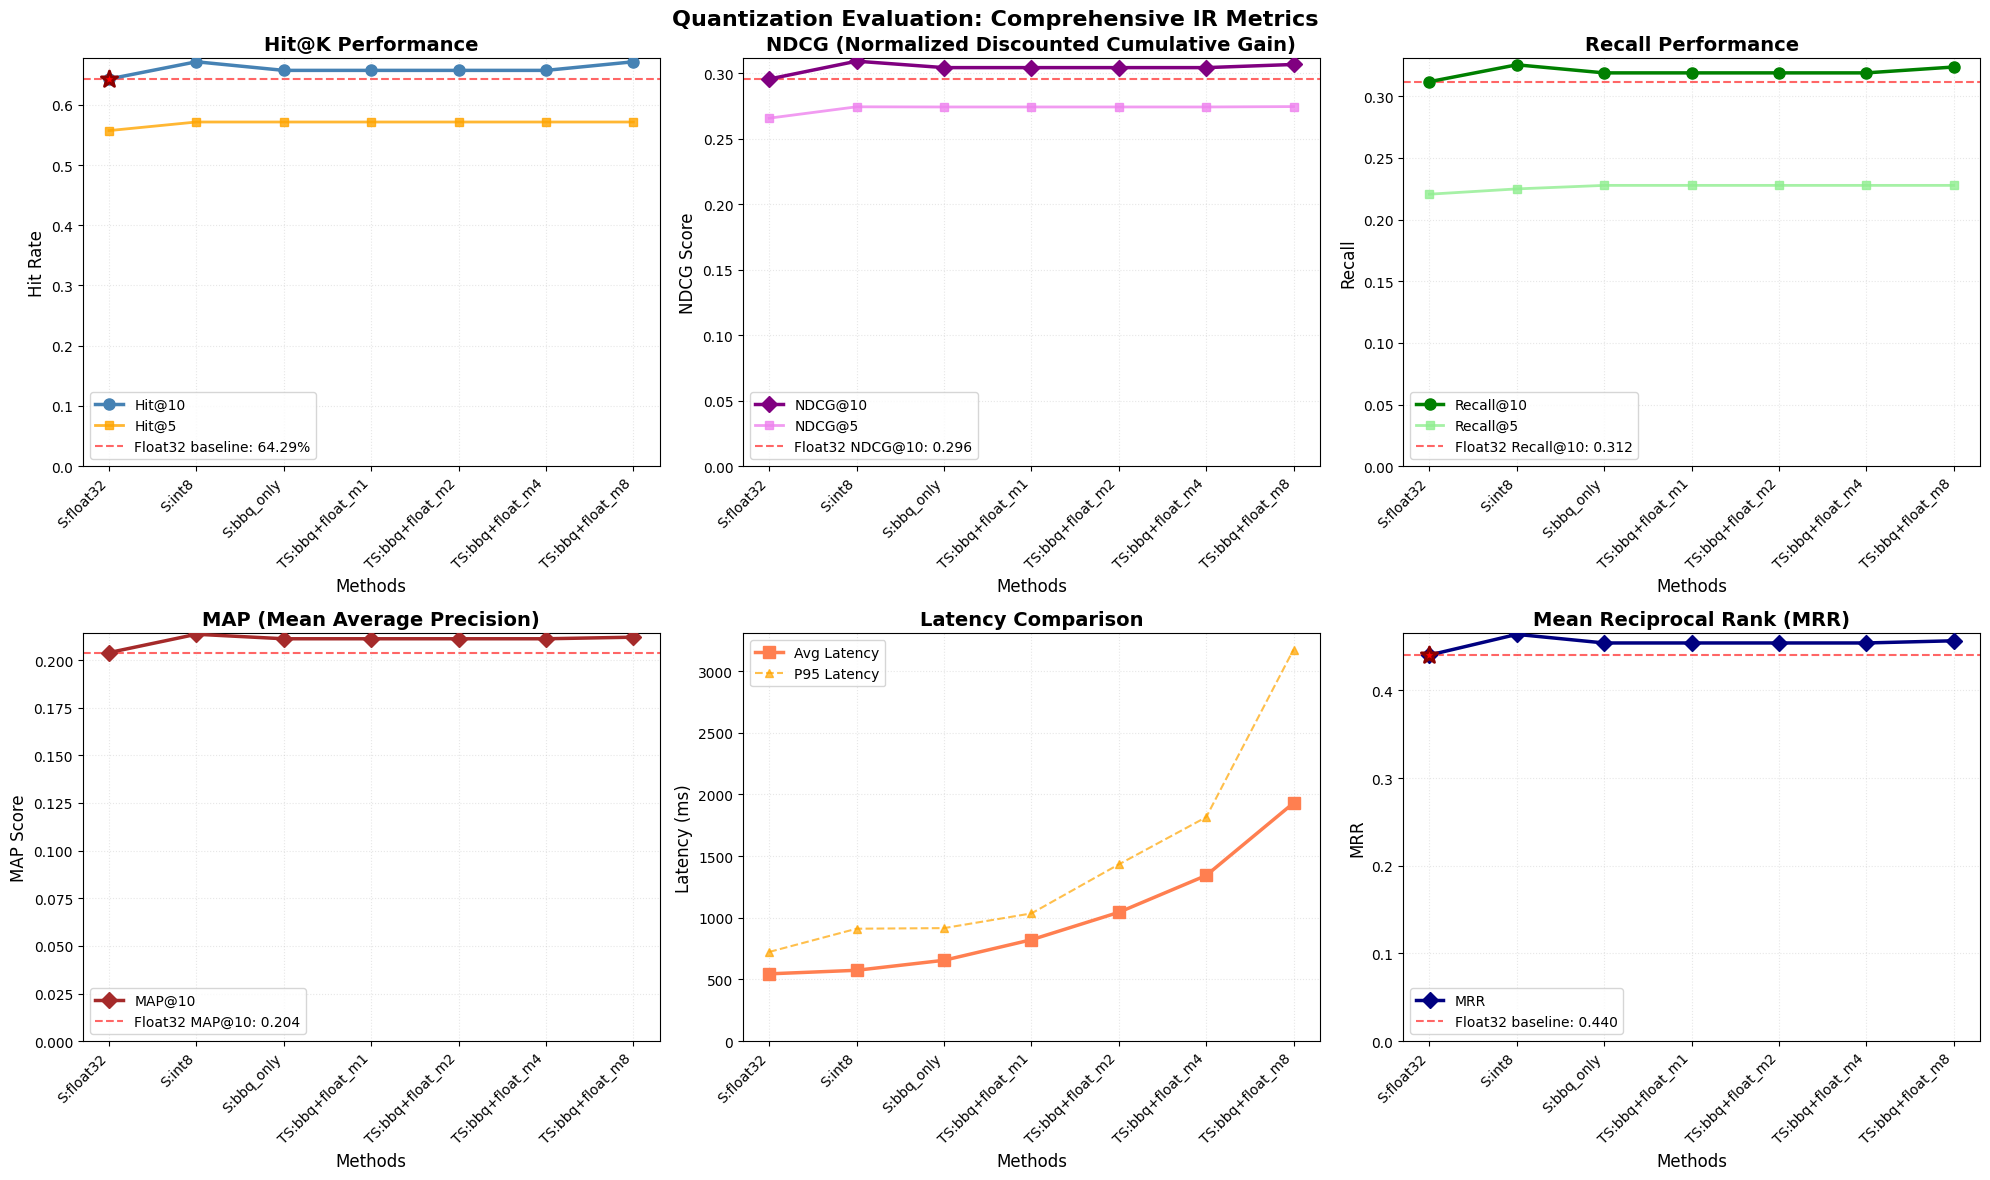

📊 Visualizations saved to /home/resti/glair/gen-ai/notebook_experiment/experiment_embedding_quantization/quantization_results/quantization_comparison.png


In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Quantization Evaluation: Comprehensive IR Metrics", fontsize=16, fontweight="bold")

# Prepare data
labels_short = summary_df["label"].str.replace("single:", "S:").str.replace("two_stage:", "TS:")
x_indices = np.arange(len(summary_df))
baseline_matches = summary_df[summary_df["label"] == "single:float32"].index
baseline_idx = int(baseline_matches[0]) if len(baseline_matches)>0 else 0

# 1. Hit@K comparison
ax = axes[0, 0]
ax.plot(x_indices, summary_df["hit@10"], linewidth=2.5, color="steelblue", 
        marker="o", markersize=8, label="Hit@10", zorder=3)
ax.plot(x_indices, summary_df["hit@5"], linewidth=2, color="orange", 
        marker="s", markersize=6, label="Hit@5", alpha=0.8, zorder=2)
ax.axhline(y=summary_float["hit@10"], color="red", linestyle="--", 
           alpha=0.6, linewidth=1.5, label=f"Float32 baseline: {summary_float['hit@10']:.2%}", zorder=1)
ax.scatter(baseline_idx, summary_float["hit@10"], color="red", s=150, 
          marker="*", zorder=4, edgecolors="darkred", linewidths=2)
ax.set_title("Hit@K Performance", fontsize=14, fontweight="bold")
ax.set_ylabel("Hit Rate", fontsize=12)
ax.set_xlabel("Methods", fontsize=12)
ax.set_xticks(x_indices)
ax.set_xticklabels(labels_short, rotation=45, ha="right")
ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.8)
ax.legend(loc="best")
ax.set_ylim(bottom=0)

# 2. NDCG comparison
ax = axes[0, 1]
if 'ndcg_cut_10' in summary_df.columns:
    ax.plot(x_indices, summary_df["ndcg_cut_10"], linewidth=2.5, color="purple", 
            marker="D", markersize=8, label="NDCG@10", zorder=3)
    ax.plot(x_indices, summary_df["ndcg_cut_5"], linewidth=2, color="violet", 
            marker="s", markersize=6, label="NDCG@5", alpha=0.8, zorder=2)
    ax.axhline(y=summary_float.get("ndcg_cut_10", 0), color="red", linestyle="--", 
               alpha=0.6, linewidth=1.5, label=f"Float32 NDCG@10: {summary_float.get('ndcg_cut_10', 0):.3f}", zorder=1)
    ax.set_title("NDCG (Normalized Discounted Cumulative Gain)", fontsize=14, fontweight="bold")
    ax.set_ylabel("NDCG Score", fontsize=12)
    ax.set_xlabel("Methods", fontsize=12)
    ax.set_xticks(x_indices)
    ax.set_xticklabels(labels_short, rotation=45, ha="right")
    ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.8)
    ax.legend(loc="best")
    ax.set_ylim(bottom=0)
else:
    ax.text(0.5, 0.5, "NDCG data not available", ha="center", va="center", fontsize=12)

# 3. Recall comparison
ax = axes[0, 2]
if 'recall_10' in summary_df.columns:
    ax.plot(x_indices, summary_df["recall_10"], linewidth=2.5, color="green", 
            marker="o", markersize=8, label="Recall@10", zorder=3)
    ax.plot(x_indices, summary_df["recall_5"], linewidth=2, color="lightgreen", 
            marker="s", markersize=6, label="Recall@5", alpha=0.8, zorder=2)
    ax.axhline(y=summary_float.get("recall_10", 0), color="red", linestyle="--", 
               alpha=0.6, linewidth=1.5, label=f"Float32 Recall@10: {summary_float.get('recall_10', 0):.3f}", zorder=1)
    ax.set_title("Recall Performance", fontsize=14, fontweight="bold")
    ax.set_ylabel("Recall", fontsize=12)
    ax.set_xlabel("Methods", fontsize=12)
    ax.set_xticks(x_indices)
    ax.set_xticklabels(labels_short, rotation=45, ha="right")
    ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.8)
    ax.legend(loc="best")
    ax.set_ylim(bottom=0)
else:
    ax.text(0.5, 0.5, "Recall data not available", ha="center", va="center", fontsize=12)

# 4. MAP comparison
ax = axes[1, 0]
if 'map_cut_10' in summary_df.columns:
    ax.plot(x_indices, summary_df["map_cut_10"], linewidth=2.5, color="brown", 
            marker="D", markersize=8, label="MAP@10", zorder=3)
    ax.axhline(y=summary_float.get("map_cut_10", 0), color="red", linestyle="--", 
               alpha=0.6, linewidth=1.5, label=f"Float32 MAP@10: {summary_float.get('map_cut_10', 0):.3f}", zorder=1)
    ax.set_title("MAP (Mean Average Precision)", fontsize=14, fontweight="bold")
    ax.set_ylabel("MAP Score", fontsize=12)
    ax.set_xlabel("Methods", fontsize=12)
    ax.set_xticks(x_indices)
    ax.set_xticklabels(labels_short, rotation=45, ha="right")
    ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.8)
    ax.legend(loc="best")
    ax.set_ylim(bottom=0)
else:
    ax.text(0.5, 0.5, "MAP data not available", ha="center", va="center", fontsize=12)

# 5. Latency comparison
ax = axes[1, 1]
ax.plot(x_indices, summary_df["avg_total_time_ms"], linewidth=2.5, color="coral", 
        marker="s", markersize=8, label="Avg Latency", zorder=3)
ax.plot(x_indices, summary_df["p95_total_time_ms"], linewidth=1.5, color="orange", 
        marker="^", markersize=6, linestyle="--", alpha=0.7, label="P95 Latency", zorder=2)
ax.set_title("Latency Comparison", fontsize=14, fontweight="bold")
ax.set_ylabel("Latency (ms)", fontsize=12)
ax.set_xlabel("Methods", fontsize=12)
ax.set_xticks(x_indices)
ax.set_xticklabels(labels_short, rotation=45, ha="right")
ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.8)
ax.legend(loc="best")
ax.set_ylim(bottom=0)

# 6. MRR comparison
ax = axes[1, 2]
ax.plot(x_indices, summary_df["mrr"], linewidth=2.5, color="navy", 
        marker="D", markersize=8, label="MRR", zorder=3)
ax.axhline(y=summary_float["mrr"], color="red", linestyle="--", 
           alpha=0.6, linewidth=1.5, label=f"Float32 baseline: {summary_float['mrr']:.3f}", zorder=2)
ax.scatter(baseline_idx, summary_float["mrr"], color="red", s=150, 
          marker="*", zorder=4, edgecolors="darkred", linewidths=2)
ax.set_title("Mean Reciprocal Rank (MRR)", fontsize=14, fontweight="bold")
ax.set_ylabel("MRR", fontsize=12)
ax.set_xlabel("Methods", fontsize=12)
ax.set_xticks(x_indices)
ax.set_xticklabels(labels_short, rotation=45, ha="right")
ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.8)
ax.legend(loc="best")
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "quantization_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"📊 Visualizations saved to {OUTPUT_DIR / 'quantization_comparison.png'}")

## 5. Save Results

In [17]:
summary_df.to_csv(OUTPUT_DIR / "quantization_summary.csv", index=False)
print(f"💾 Summary saved to {OUTPUT_DIR / 'quantization_summary.csv'}")

all_details.to_csv(OUTPUT_DIR / "quantization_details.csv", index=False)
print(f"💾 Details saved to {OUTPUT_DIR / 'quantization_details.csv'}")

report = f"""
QUANTIZATION EVALUATION REPORT (WITH CLASSICAL IR METRICS)
{'='*80}

Test Configuration:
- Dataset: {len(df)} queries
- Embedding Model: text-embedding-3-small (1536 dims)
- Elasticsearch Indices: {', '.join(INDICES.values())}
- K: 10
- Evaluation Metrics: Hit@K, MRR, NDCG, MAP, Recall, Precision

Summary Results:
"""

report_cols = ['label', 'hit@10', 'mrr', 'ndcg_cut_10', 'map_cut_10', 'recall_10', 'avg_total_time_ms', 'p95_total_time_ms']
available_report_cols = [col for col in report_cols if col in summary_df.columns]
report += summary_df[available_report_cols].to_string(index=False)

report += f"""

Key Findings:
1. Float32 Baseline:
   - Hit@10: {summary_float['hit@10']*100:.1f}%
   - NDCG@10: {summary_float.get('ndcg_cut_10', 0):.3f}
   - Recall@10: {summary_float.get('recall_10', 0):.3f}
   - MAP@10: {summary_float.get('map_cut_10', 0):.3f}
   - Latency: {summary_float['avg_total_time_ms']:.2f}ms

2. Int8 Quantization:
   - Hit@10: {summary_int8['hit@10']/summary_float['hit@10']*100:.1f}% of baseline
   - NDCG@10: {(summary_int8.get('ndcg_cut_10', 0)/summary_float.get('ndcg_cut_10', 1))*100:.1f}% of baseline
   - Recall@10: {(summary_int8.get('recall_10', 0)/summary_float.get('recall_10', 1))*100:.1f}% of baseline
   - Speed: {summary_float['avg_total_time_ms']/summary_int8['avg_total_time_ms']:.2f}x faster

3. BBQ (Binary) Quantization:
   - Hit@10: {summary_bbq['hit@10']/summary_float['hit@10']*100:.1f}% of baseline
   - NDCG@10: {(summary_bbq.get('ndcg_cut_10', 0)/summary_float.get('ndcg_cut_10', 1))*100:.1f}% of baseline
   - Recall@10: {(summary_bbq.get('recall_10', 0)/summary_float.get('recall_10', 1))*100:.1f}% of baseline
   - Speed: {summary_float['avg_total_time_ms']/summary_bbq['avg_total_time_ms']:.2f}x faster

"""

with open(OUTPUT_DIR / "quantization_report.txt", "w") as f:
    f.write(report)

print(f"💾 Report saved to {OUTPUT_DIR / 'quantization_report.txt'}")
print("\n" + report)

💾 Summary saved to /home/resti/glair/gen-ai/notebook_experiment/experiment_embedding_quantization/quantization_results/quantization_summary.csv
💾 Details saved to /home/resti/glair/gen-ai/notebook_experiment/experiment_embedding_quantization/quantization_results/quantization_details.csv
💾 Report saved to /home/resti/glair/gen-ai/notebook_experiment/experiment_embedding_quantization/quantization_results/quantization_report.txt


QUANTIZATION EVALUATION REPORT (WITH CLASSICAL IR METRICS)

Test Configuration:
- Dataset: 70 queries
- Embedding Model: text-embedding-3-small (1536 dims)
- Elasticsearch Indices: claudiagpt_dev_catapa_platform_development, claudiagpt_dev_catapa_platform_development_int8, claudiagpt_dev_catapa_platform_development_bbq
- K: 10
- Evaluation Metrics: Hit@K, MRR, NDCG, MAP, Recall, Precision

Summary Results:
                 label   hit@10      mrr  ndcg_cut_10  map_cut_10  recall_10  avg_total_time_ms  p95_total_time_ms
        single:float32 0.642857 0.440215   